# Previsão de preços de aluguéis temporários em Nova York
## Processo seletivo Lightouse-Indicium 2024

**Autor**: Igor Samesima Giner

**Objetivos**:
- Realizar análise exploratória de dados de aluguéis temporários na cidade de Nova York;
- Desenvolver modelo de previsão de preços de aluguéis temporários na cidade de Nova York;
- Avaliar o modelo desenvolvido;
- Testar o modelo desenvolvido com novos dados.

Os dados utilizados neste relatório são aqueles fornecidos pela própria Indicium (teste_indicium_precificacao.csv).

## Dependências

Os seguintes pacotes são necessários:
- Matplotlib (3.8.3)
- Pandas (2.2.0)
- Numpy (1.26.4)
- Seaborn (0.13.2)
- Scikit-learn (1.4.1)
- nltk (3.8.1)

In [742]:
# Importar os pacotes necessários
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Obtenção dos dados

In [743]:
# Carregar os dados
diretorio = "C:/Users/igorg/Documents/house_pricing_project" # Caminho em seu sistema onde o arquivo está armazenado
data = pd.read_csv(f"{diretorio}/teste_indicium_precificacao.csv")

# 2) Análise exploratória de dados (EDA)
## 2.1) Análise da estrutura dos dados

In [744]:
# Entender a estrutura dos dados
data.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73975.00000,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [745]:
# Ver informação básica
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

É possível obsevar que:
- Trata-se de dados de anúncios de aluguel temporário, organizado em DataFrame;
- Cada linha (observação) se refere a um anúncio (total = 48894);
- Há um total de 16 colunas (características);
- `id` e `host_id` parecem ser características irrelevantes para o problema em questão;
- Há sinais de que existem valores nulos (em `nome`, `host_name`, `ultima_review` e `reviews_por_mes`), que serão tratados em seguida.
- A coluna `price` está no formato *int64*. Talvez seja interessante converter para o formato *float64*, a fim de prevenir possíveis erros em análises subsequentes;
- A coluna `room_type` está no formato *object*, o que talvez não seja o mais adequado. Pode ser interessante converter para o formato *category*.

## 2.2) Limpeza e pré-processamento dos dados

É fundamental realizar a limpeza e melhoria dos dados antes das análises estatísticas da fasee exploratória. Dados sujos, incompletos ou inconsistentes podem levar a conclusões erradas. Ao limpar os dados, garantimos precisão, facilitamos a identificação de padrões e economizamos tempo no processo de análise

### 2.2.1) Remoção de características irrelevantes para o problema

In [746]:
# Remover as colunas "id", "host_id" e "host_name" do DataFrame, pois aparentam ser irrelevantes para a resolução do problema
data.drop(['id', 'host_id', 'host_name'], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   nome                           48878 non-null  object 
 1   bairro_group                   48894 non-null  object 
 2   bairro                         48894 non-null  object 
 3   latitude                       48894 non-null  float64
 4   longitude                      48894 non-null  float64
 5   room_type                      48894 non-null  object 
 6   price                          48894 non-null  int64  
 7   minimo_noites                  48894 non-null  int64  
 8   numero_de_reviews              48894 non-null  int64  
 9   ultima_review                  38842 non-null  object 
 10  reviews_por_mes                38842 non-null  float64
 11  calculado_host_listings_count  48894 non-null  int64  
 12  disponibilidade_365            48894 non-null 

### 2.2.2) Verificação de dados duplicados

In [747]:
# Verificar se existem dados duplicados
dados_duplicados = data.duplicated().any()

if dados_duplicados:
    print("Existem dados duplicados no conjunto de dados analisado.")
else:
    print("Não existem dados duplicados no conjunto de dados analisado.")

Não existem dados duplicados no conjunto de dados analisado.


### 2.2.3) Verificação de valores nulos

Observamos no item 2.1 que é provável que existam valores nulos no conjunto de dados em questão. Vamos confirmar isso.

In [748]:
# Verificar se há valores nulos
valores_nulos = data.isnull().any()

# Verificar quais colunas possuem valores nulos
if valores_nulos.any():
    print("Existem valores nulos no conjunto analisado.")
    print(valores_nulos[valores_nulos])
else:
    print("Não existem valores nulos no conjunto analisado.")

Existem valores nulos no conjunto analisado.
nome               True
ultima_review      True
reviews_por_mes    True
dtype: bool


In [749]:
# Verificar a quantidade de valores nulos por coluna
valores_nulos_por_coluna = data.isnull().sum()
print(valores_nulos_por_coluna)

nome                                16
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64


A **maioria dos valores nulos concentram-se nas colunas `ultima_review` e `reviews_por_mes`**.

In [750]:
# Calcular o número de observações com pelo menos um valor nulo
observacoes_com_nulos = data[data.isnull().any(axis=1)]

# Número total de observações com pelo menos um valor nulo
total_observacoes_com_nulos = len(observacoes_com_nulos)

print(f"Você perderia {total_observacoes_com_nulos} observações se excluísse as linhas com valores nulos.")

Você perderia 10058 observações se excluísse as linhas com valores nulos.


**Remover 10058 observações parece arriscado, uma vez que é 20,57% do conjunto de dados**. Isso poderia influenciar a análise de forma substancial. 

São poucas as observações sem `nome`, e a remoção delas provavelmente não impacta profundamente em nossas análises.

In [751]:
# Remover observações com valores nulos nas colunas "nome" e "host_name"
data.dropna(subset=['nome'], inplace=True)

# Verificar a quantidade de valores nulos por coluna
valores_nulos_por_coluna = data.isnull().sum()
print(valores_nulos_por_coluna)

nome                                 0
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10042
reviews_por_mes                  10042
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64


A característica `ultima_review` contém uma proporção significativa de valores nulos e não parece ser uma característica de impacto para nosso objetivo. Ainda, é razoável pensar que ela não pode ser imputada de maneira confiável. Portanto, vamos removê-la.

In [752]:
# Excluir a coluna "ultima_review"
data.drop(columns=['ultima_review'], inplace=True)

# Verificar a quantidade de valores nulos por coluna
valores_nulos_por_coluna = data.isnull().sum()
print(valores_nulos_por_coluna)

nome                                 0
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
reviews_por_mes                  10042
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64


Por outro lado, **a característica`reviews_por_mes` parece promissora**, uma vez que é razoável imaginar que quanto mais reviews um anúncio tiver, maior será sua confiabilidade e visibilidade; desta maneira, os locatários podem interpretar que o imóvel é de melhor qualidade, agregando valor ao mesmo. Portanto, `reviews_por_mes` pode estar correlacionada com o preço do aluguel. Assim, é adequado verificar alguma maneira para manter esta característica no conjunto.

### 2.2.4) Imputação de dados

Como desejamos manter `reviews_por_mes`, devemos realizar um processo de imputação de dados, a fim de **substituir os valores nulos por uma estimativa razoável**. Neste caso, utilizaremos a **mediana**, uma vez que ela é mais robusta em relação a outliers e é menos afetada por distribuições assimétricas (ainda não conhecemos a distribuição dessa característica).

In [753]:
# Calcular a mediana dos valores não nulos na coluna 'reviews_por_mes'
mediana_reviews_por_mes = data['reviews_por_mes'].median()

# Substituir os valores faltantes na coluna 'reviews_por_mes' pela mediana calculada
data['reviews_por_mes'] = data['reviews_por_mes'].fillna(mediana_reviews_por_mes)

# Verificar a quantidade de valores nulos por coluna após a imputação em "reviews_por_mes"
valores_nulos_por_coluna = data.isnull().sum()
print(valores_nulos_por_coluna)

nome                             0
bairro_group                     0
bairro                           0
latitude                         0
longitude                        0
room_type                        0
price                            0
minimo_noites                    0
numero_de_reviews                0
reviews_por_mes                  0
calculado_host_listings_count    0
disponibilidade_365              0
dtype: int64


Podemos observar que a imputação de dados em `reviews_por_mes` funcionou, uma vez que **a quantidade de valores nulos nessa coluna reduziu a 0**.

Desta maneira, **o resultado é um DataFrame sem valores nulos**, o que pode simplificar nossas análises, evitar viés em nossos resultados, prevenir erros em modelos de *machine learning* e melhorar a visualização dos dados.

### 2.2.5) Alteração de formatos de dados

In [754]:
# Converter coluna "price" de int64 para float64
data['price'] = data['price'].astype(float)
data.price.info()

<class 'pandas.core.series.Series'>
Index: 48878 entries, 0 to 48893
Series name: price
Non-Null Count  Dtype  
--------------  -----  
48878 non-null  float64
dtypes: float64(1)
memory usage: 763.7 KB


Converter a coluna `price` de `int64` para `float64` pode ser interessante, uma vez que alguns cálculos matemáticos podem exigir que os valores sejam do tipo *float*. Ainda, isso pode ser útil ao compararmos, futuramente, `price` com outras grandezas representadas como *floats*.

In [755]:
# Converter coluna "room_type" de object para category
data['room_type'] = data['room_type'].astype('category')
data.room_type.info()

<class 'pandas.core.series.Series'>
Index: 48878 entries, 0 to 48893
Series name: room_type
Non-Null Count  Dtype   
--------------  -----   
48878 non-null  category
dtypes: category(1)
memory usage: 429.7 KB


Converter a coluna `room_type` de `object` para `category` pode economizar memória e melhorar a eficiência em certas operações.

## 2.3) Estatística básica
### 2.3.1) Características numéricas

Ao analisar características numéricas, uma abordagem comum é utilizar o método `describe()` para obter estatísticas descritivas resumidas dos dados, como média, desvio padrão, quartis e valores mínimo e máximo. Isso nos permite ter uma visão geral da distribuição dos dados.

In [756]:
# Utilizar describe() para gerar sumário das características numéricas.
data.describe()

,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,48878.000000,48878.000000,48878.000000,48878.000000,48878.000000,48878.000000,48878.000000,48878.000000
mean,390.346020,-760.174645,152.722431,7.011150,23.281497,1.239190,7.145914,112.783829
std,3755.394306,7087.154370,240.189261,20.016187,44.556558,1.521052,32.958075,131.609725
min,40.499790,-74142.000000,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690340,-73.983620,69.000000,1.000000,1.000000,0.280000,1.000000,0.000000
50%,40.723630,-73.956010,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763838,-73.936620,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,40896.000000,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


Podemos notar que existem sinais de possíveis **outliers** no conjunto de dados:

- Valor máximo de `latitude` = 40896.000000 (valor impossível);
- Valor mínimo de `longitude` = -74142.000000 (valor impossível);
- Valor mínimo de `price` = 0.000000 (valor impossível);
- Valor máximo de `price` = 10000.000000, enquanto Q3 (75%) = 175.000000;
- Valor máximo de `calculado_host_listings_count` = 327.000000, enquanto mediana (50%) = 1.000000 e Q3 (75%) = 2.000000;
- Valor máximo de `minimo_noites` = 1250.000000, enquanto mediana (50%) = 3.000000 e Q3 (75%) = 5.000000.

A visualização dos dados utilizando histogramas ou boxplots, por exemplo, podem nos ajudar a identificar os outliers.

<Axes: >

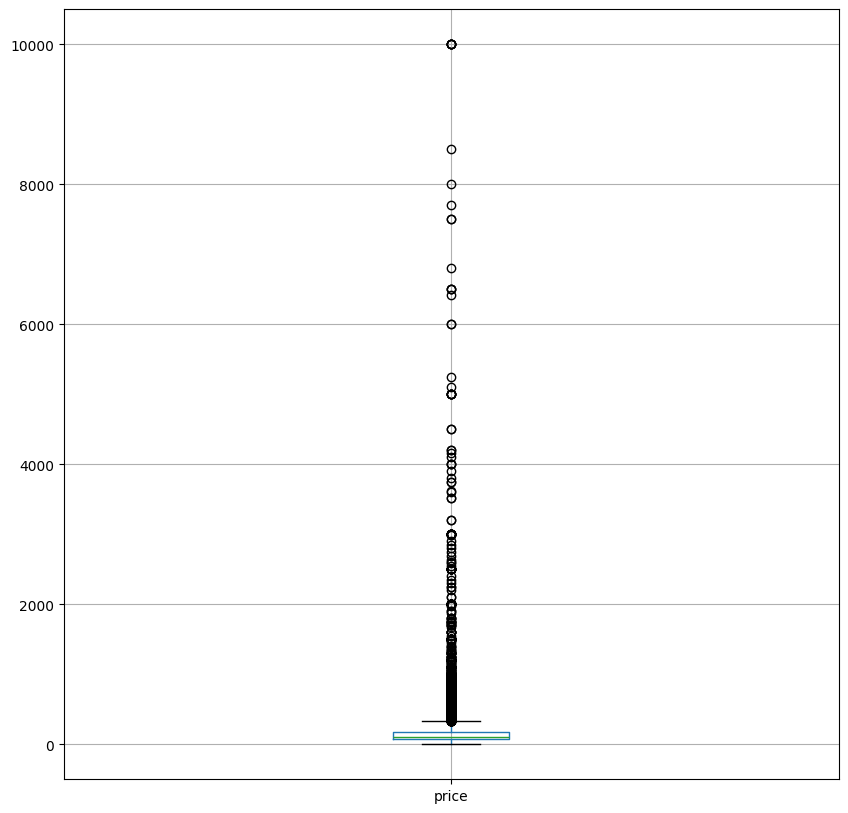

In [757]:
# Gerar boxplot para "price".
data.boxplot(['price'], figsize = (10,10))

O boxplot reforça a possibilidade existência de outliers na coluna `price`, a **variável alvo deste projeto**. A média dos preços é de \\$152,72, e 75% dos preços estão abaixo de \\$175,00. No entanto, existem valores tão altos quanto \\$10.000,00.

Text(0, 0.5, 'Frequência')

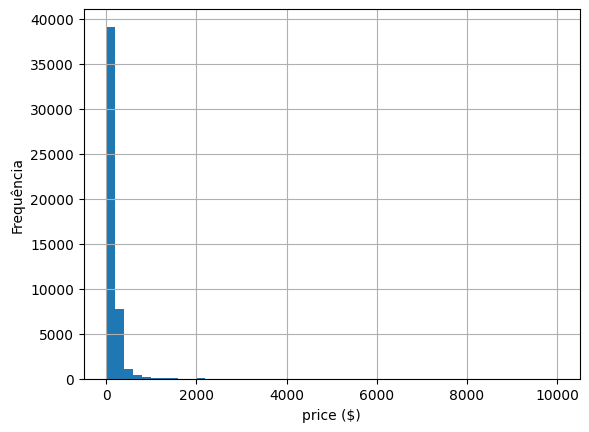

In [758]:
# Gerar histograma para "price".
data['price'].hist(bins = 50)
plt.xlabel('price ($)')
plt.ylabel('Frequência')

A presença de outliers também é reforçada na visualização do histograma da varíavel `price`. **Os valores exarcebados serão tratados posteriormente**.

Quanto à sua distribuição, `price` parece seguir uma tendência de  **assimetria positiva (Right-Skewed Distribution)**. Isso indica uma concentração maior de dados na parte esquerda da distribuição, com uma cauda mais longa estendendo-se para a direita.


Vamos visualizar os boxplots e os histogramas das variáveis numéricas restantes.

<Axes: >

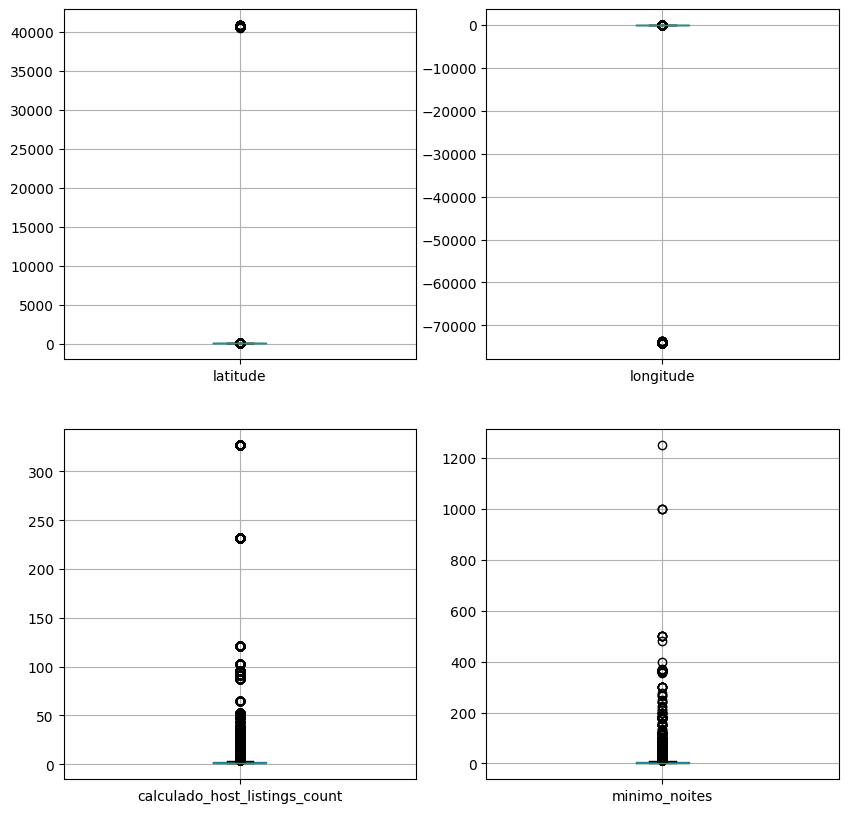

In [759]:
# Gerar boxplot para outras características numéricas de interesse com suspeitas de outliers
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)  # 2 linhas, 2 colunas, gráfico 1
data.boxplot(['latitude'], figsize = (10,10))

plt.subplot(2, 2, 2)  # 2 linhas, 2 colunas, gráfico 2
data.boxplot(['longitude'], figsize = (10,10))

plt.subplot(2, 2, 3)  # 2 linhas, 2 colunas, gráfico 3
data.boxplot(['calculado_host_listings_count'], figsize = (10,10))

plt.subplot(2, 2, 4)  # 2 linhas, 2 colunas, gráfico 4
data.boxplot(['minimo_noites'], figsize = (10,10))

array([[<Axes: title={'center': 'calculado_host_listings_count'}>,
        <Axes: title={'center': 'disponibilidade_365'}>,
        <Axes: title={'center': 'latitude'}>],
       [<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'minimo_noites'}>,
        <Axes: title={'center': 'numero_de_reviews'}>],
       [<Axes: title={'center': 'reviews_por_mes'}>, <Axes: >, <Axes: >]],
      dtype=object)

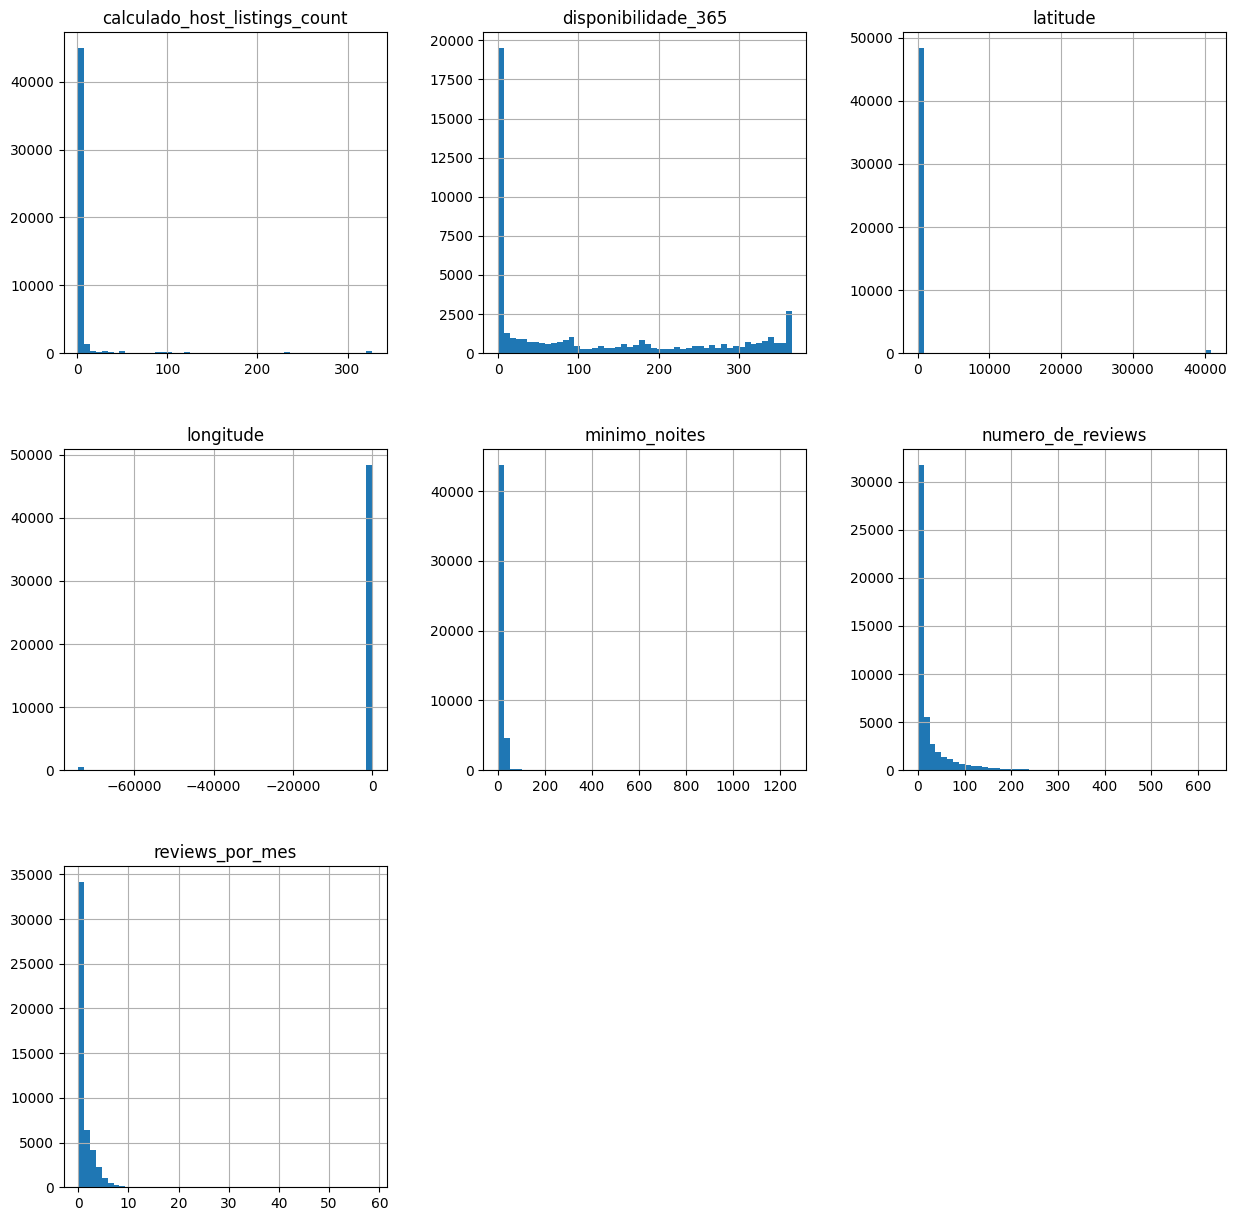

In [760]:
# Desconsiderar a coluna 'price', uma vez que já plotamos seu histograma logo acima.
col_para_hist = data.columns.difference(['price'])

# Gerar Histograma
data[col_para_hist].hist(bins = 50, figsize = (15,15))

`minimo_noites`, `número_de_reviews`, `reviews_por_mes` e, possivelmente, `disponibilidade_365` aparentam seguir, também, uma distribuição com assimetria positiva (*Right-Skewed Distribution*)

Os boxplots e os histogramas reforçam a possibilidade de existência de outliers também em `latitude`, `longitude`, `calculado_host_listings_count` e `mínimo_noites`. **Os valores exarcebados serão analisados e tratados em seguida**.

#### 2.3.1.1) Análise e manejo de outliers

Previamente, detectamos potenciais outliers nas em `price`, `latitude`, `longitude`, `calculado_host_listings_count` e `minimo_noites`. Agora, precisamos avaliar se é apropriado remover ou manter esses valores extremos no conjunto de dados, considerando o contexto do nosso projeto de precificação de aluguéis.

- Avaliando a coluna `price`:

In [761]:
# Analisar o Top 50 anúncios mais caros
data.sort_values(by='price', ascending=False).head(50)

,nome,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
9150,Furnished room in Astoria apartment,Queens,Astoria,40.76810,-73.91651,Private room,10000.0,100,2,0.04,1,0
29237,1-BR Lincoln Center,Manhattan,Upper West Side,40.77213,-73.98665,Entire home/apt,10000.0,30,0,0.72,1,83
17691,Luxury 1 bedroom apt. -stunning Manhattan views,Brooklyn,Greenpoint,40.73260,-73.95739,Entire home/apt,10000.0,5,5,0.16,1,0
12341,"Quiet, Clean, Lit @ LES & Chinatown",Manhattan,Lower East Side,40.71355,-73.98507,Private room,9999.0,99,6,0.14,1,83
40432,2br - The Heart of NYC: Manhattans Lower East ...,Manhattan,Lower East Side,40.71980,-73.98566,Entire home/apt,9999.0,30,0,0.72,1,365
6529,Spanish Harlem Apt,Manhattan,East Harlem,40.79264,-73.93898,Entire home/apt,9999.0,5,1,0.02,1,0
30267,Beautiful/Spacious 1 bed luxury flat-TriBeCa/Soho,Manhattan,Tribeca,40.72197,-74.00633,Entire home/apt,8500.0,30,2,0.18,1,251
4376,Film Location,Brooklyn,Clinton Hill,40.69137,-73.96723,Entire home/apt,8000.0,1,1,0.03,11,365
29661,East 72nd Townhouse by (Hidden by Airbnb),Manhattan,Upper East Side,40.76824,-73.95989,Entire home/apt,7703.0,1,0,0.72,12,146
45665,Gem of east Flatbush,Brooklyn,East Flatbush,40.65724,-73.92450,Private room,7500.0,1,8,6.15,2,179


Aparentemente, os valores até então considerados como outliers **parecem ser representações de situações reais**. Podemos observar na coluna `nome` algumas informações que podem justificar o preço elevado desses anúncios. A maioria dos locais é do tipo "Entire home/apt" e encontra-se em Manhattan, um dos locais com maior custo de vida dos Estados Unidos (fonte: https://www.cnbc.com/2023/08/22/us-cities-with-the-highest-cost-of-living.html#:~:text=1,-Published%20Tue%2C%20Aug&text=New%20York%27s%20Manhattan%20borough%20is,than%20double%20the%20national%20average.). 

Além disso, **é possível observar a presença de palavras como *Luxury* (luxo), *Furnished* (mobiliado), *Duplex*, *Mansion* (mansão), *Midtown*, *SuperBowl* e até mesmo *Yacth* (iate), que revelam características que, geralmente, agregam valor à propriedade e/ou estão relacionadas ao estilo de vida de alto padrão**.

Entretanto, por se tratar de nossa variável de interesse, vamos retirar alguns valores exarcebados – tentando manter uma abordagem conservadora-flexível, pois vimos que podem existir justificativas para os maiores preços.

In [762]:
# Identificar os outliers na coluna 'price' com base em um intervalo interquartil de 99.8%
limite_inferior = data['price'].quantile(0.001)
limite_superior = data['price'].quantile(0.999)

# Identificar valores fora do intervalo interquartil
valores_fora_intervalo = data[(data['price'] < limite_inferior) | (data['price'] > limite_superior)]

# Contar o número de valores fora do intervalo
num_valores_fora_intervalo = len(valores_fora_intervalo)
print(f"Número de valores fora do intervalo interquartil: {num_valores_fora_intervalo}")

Número de valores fora do intervalo interquartil: 93


Serão removidas apenas 93 observações, o que não causa uma perda significativa ao conjunto de dados.

In [763]:
# Remover os outliers
data = data[(data['price'] >= limite_inferior) & (data['price'] <= limite_superior)]

# Visualizar as primeiras linhas do DataFrame sem outliers de `price`
data.sort_values(by='price', ascending=False).head()

,nome,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
38222,Luxury West Village private Townhouse 5B Garden,Manhattan,Gramercy,40.73652,-73.98618,Entire home/apt,3000.0,1,1,0.15,1,365
18631,Breathtaking City Views 3 Bed Apt. in Lincoln Sq!,Manhattan,Upper West Side,40.77910,-73.98182,Entire home/apt,3000.0,30,8,0.24,11,365
39845,CQ 1 Bedroom,Manhattan,Financial District,40.70706,-74.00991,Private room,3000.0,3,0,0.72,1,23
28726,The room boom,Brooklyn,Brighton Beach,40.58363,-73.96405,Private room,3000.0,1,0,0.72,1,90
28857,SPECTACULAR SOHO GREAT ROOM LOFT 6000sq feet,Manhattan,SoHo,40.72605,-74.00572,Entire home/apt,3000.0,7,1,1.00,1,325


O código acima remove tanto os outliers superiores quanto os inferiores com base nos limites definidos pelos percentis. No caso, os outliers foram definidos como valores abaixo do percentil 0.1 e acima do percentil 99.9 da distribuição da coluna 'price'. **Isso garante que tanto os valores extremamente baixos quanto os extremamente altos sejam considerados outliers e removidos do conjunto de dados (flexibilização)**.

In [764]:
# Verificar "price" após a remoção dos outliers
data.price.describe()

count    48785.000000
mean       147.720303
std        157.523296
min         18.000000
25%         69.000000
50%        106.000000
75%        175.000000
max       3000.000000
Name: price, dtype: float64

Aparentemente, após a remoção de outliers de `price`, temos um **resultado mais realístico**. O valor de aluguel de $0,00 foi retirado, juntamente com valores muito exarcebados. Porém, ainda estamos englobando em nosso conjunto de dados as propriedades luxuosas (max = \\$3.000,00).

- Avaliando a coluna `latitute`

Ao contrário de `price`, em `latitute` fica mais evidente a possibilidade de erros de digitação. A latitude é uma medida angular que varia de -90° a +90°. Valores menores ou maiores do que estes são impossíveis.

In [765]:
# Investigar valores impossíveis em "latitude"
out_of_range_lat = data[(data['latitude'] < -90) | (data['latitude'] > 90)]
out_of_range_lat.head()

,nome,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
125,Garden studio in the Upper East Sid,Manhattan,Upper East Side,40778.0,-73.94822,Entire home/apt,150.0,5,21,0.19,1,189
215,1 Bedroom Loft w/ Private Roof Deck,Brooklyn,Greenpoint,40729.0,-73.95829,Entire home/apt,195.0,2,69,0.65,1,58
247,BROWNSTONE SUNDRENCHED BEAUTY,Brooklyn,Bushwick,40688.0,-73.91710,Entire home/apt,99.0,3,111,2.13,1,68
294,The Cozy Brownstone Inn (discount)!,Brooklyn,Bedford-Stuyvesant,40683.0,-73.91981,Entire home/apt,145.0,3,127,1.25,2,72
407,"Private, spacious room in Brooklyn",Brooklyn,East Flatbush,40651.0,-73.94886,Private room,50.0,2,263,2.69,2,136


In [766]:
length_out_of_range_lat = len(out_of_range_lat)
print("Número de observações com latitude fora do intervalo:", length_out_of_range_lat)

Número de observações com latitude fora do intervalo: 417


Existe uma quantidade considerável de observações com valores impossíveis de `latitude`. Desta maneira, vamos tentar **normalizar** esses valores antes de pensar em excluir as observações em questão.

In [767]:
min_latitude_out_of_range = out_of_range_lat['latitude'].min()
print("Valor mínimo de latitude fora do intervalo válido:", min_latitude_out_of_range)

Valor mínimo de latitude fora do intervalo válido: 40527.0


In [768]:
max_latitude_out_of_range = out_of_range_lat['latitude'].max()
print("Valor máximo de latitude fora do intervalo válido:", max_latitude_out_of_range)

Valor máximo de latitude fora do intervalo válido: 40896.0


Parece que os valores de latitude que estão fora do intervalo válido (-90 a 90) provavelmente sofreram **erro de digitação**, resultando em valores multiplicados por 1000. Para corrigir isso, **vamos normalizar esses valores, substituindo-os por eles mesmos divididos por 1000**.

In [769]:
# Substituir os valores de latitude fora do intervalo válido por eles mesmos divididos por 1000
data.loc[(data['latitude'] < -90) | (data['latitude'] > 90), 'latitude'] /= 1000

# Verificar "latitude" após a remoção dos outliers
data.latitude.describe()

count    48785.000000
mean        40.728947
std          0.054542
min         40.499790
25%         40.690060
50%         40.723070
75%         40.763120
max         40.913060
Name: latitude, dtype: float64

**Não existem mais valores impossíveis** em `latitude`. Agora, a característica retrata a realidade de maneira confiante.

- Avaliando a coluna `longitude`

Em `longitude` também fica evidente a possibilidade de erros de digitação. A latitude é uma medida angular que varia de -180° a +180°. Valores menores ou maiores do que estes são impossíveis.

In [770]:
# Investigar valores impossíveis em "longitude"
out_of_range_long = data[(data['longitude'] < -180) | (data['longitude'] > 180)]
out_of_range_long.head()

,nome,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
4,Large Cozy 1 BR Apartment In Midtown East,Manhattan,Murray Hill,40.74767,-73975.0,Entire home/apt,200.0,3,74,0.59,1,129
91,"Large Parlor Room, Landmark Home 1 block to PRATT",Brooklyn,Clinton Hill,40.68634,-73966.0,Private room,98.0,7,16,0.20,6,185
409,The Ground Studio - West Side,Manhattan,Chelsea,40.74488,-74001.0,Entire home/apt,132.0,4,10,0.10,1,0
664,+Highly Satisfactory LES dwelling++,Manhattan,Chinatown,40.71460,-73991.0,Private room,115.0,4,151,1.63,2,323
876,Historic Brooklyn 2-Bedroom Apt,Brooklyn,Bedford-Stuyvesant,40.69213,-73951.0,Entire home/apt,135.0,2,39,0.47,2,293


In [771]:
length_out_of_range_long = len(out_of_range_long)
print("Número de observações com longitude fora do intervalo:", length_out_of_range_long)

Número de observações com longitude fora do intervalo: 454


Do mesmo modo que fizemos com `latitute`, vamos tentar normalizar os dados de `longitude`.

In [772]:
min_longitude_out_of_range = out_of_range_long['longitude'].min()
print("Valor mínimo de longitude fora do intervalo válido:", min_longitude_out_of_range)

Valor mínimo de longitude fora do intervalo válido: -74142.0


In [773]:
max_longitude_out_of_range = out_of_range_long['longitude'].max()
print("Valor máximo de longitude fora do intervalo válido:", max_longitude_out_of_range)

Valor máximo de longitude fora do intervalo válido: -73726.0


`longitude` parece sofrer o mesmo problema de `lagitude`: erro de digitação. Portanto, vamos normalizar esses valores, substituindo-os por eles mesmos divididos por 1000.

In [774]:
# Substituir os valores de longitude fora do intervalo válido por eles mesmos divididos por 1000
data.loc[(data['longitude'] < -180) | (data['longitude'] > 180), 'longitude'] /= 1000

# Verificar "longitude" após a remoção dos outliers
data.longitude.describe()

count    48785.000000
mean       -73.952158
std          0.046149
min        -74.244420
25%        -73.983050
50%        -73.955680
75%        -73.936290
max        -73.712990
Name: longitude, dtype: float64

**Não existem mais valores impossíveis** em `longitude`. Agora, a característica retrata a realidade de maneira confiante.

- Avaliando a coluna `calculado_host_listings_count`

In [775]:
# Analisar o Top 50 anúncios com maiores valores de "calculado_host_listings_count"
data.sort_values(by='calculado_host_listings_count', ascending=False).head(50)

,nome,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
41933,Sonder | The Nash | Original 1BR + Rooftop,Manhattan,Murray Hill,40.74763,-73.97524,Entire home/apt,316.0,2,5,1.17,327,76
44667,Sonder | 116 John | Relaxed 1BR + Gym,Manhattan,Financial District,40.70673,-74.00510,Entire home/apt,130.0,29,0,0.72,327,361
41484,Sonder | Stock Exchange | Pristine 1BR + Kitchen,Manhattan,Financial District,40.70620,-74.01092,Entire home/apt,229.0,2,11,2.37,327,329
43525,Sonder | Stock Exchange | Stunning 3BR + Sofa Bed,Manhattan,Financial District,40.70729,-74.01095,Entire home/apt,474.0,2,9,4.22,327,263
44521,Sonder | 116 John | Cozy 1BR + Gym,Manhattan,Financial District,40.70808,-74.00561,Entire home/apt,130.0,29,0,0.72,327,338
43524,Sonder | Stock Exchange | Tasteful 3BR + Laundry,Manhattan,Financial District,40.70599,-74.01236,Entire home/apt,472.0,2,8,3.43,327,262
43522,Sonder | The Biltmore | Stylish 1BR + Sofa Bed,Manhattan,Theater District,40.76072,-73.98582,Entire home/apt,244.0,29,1,0.88,327,363
43521,Sonder | The Biltmore | Chic 1BR + City View,Manhattan,Theater District,40.76008,-73.98721,Entire home/apt,227.0,29,0,0.72,327,365
44271,Sonder | Stock Exchange | Sunny 3BR + Sofa Bed,Manhattan,Financial District,40.70776,-74.01239,Entire home/apt,470.0,2,3,1.55,327,237
44273,Sonder | Stock Exchange | Brilliant 1BR + Laundry,Manhattan,Financial District,40.70744,-74.01048,Entire home/apt,229.0,2,2,0.82,327,331


Ao analisar as observações, podemos interpretar que a existência de valores exarcebados na coluna em questão pode ser justificada pelo fato de existirem locadores de grande porte, como, por exemplo, empresas destinadas a este fim – como a Sonder. Desta maneira, **essas observações são válidas, pois retratam a realidade no contexto do problema.** Portanto, elas devem ser consideradas nas análises e **não serão excluídas**.

- Avaliando a coluna `minimo_noites`

In [776]:
# Analisar o Top 50 anúncios com maiores valores de "minimo_noites"
data.sort_values(by='minimo_noites', ascending=False).head(50)

,nome,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
5766,Prime W. Village location 1 bdrm,Manhattan,Greenwich Village,40.73293,-73.99782,Entire home/apt,180.0,1250,2,0.03,1,365
38663,Shared Studio (females only),Manhattan,Greenwich Village,40.73094,-73.99900,Shared room,110.0,999,0,0.72,1,365
26340,Beautiful place in Brooklyn! #2,Brooklyn,Williamsburg,40.71772,-73.95059,Private room,79.0,999,24,1.12,6,249
13403,Historic Designer 2 Bed. Apartment,Manhattan,Harlem,40.82915,-73.94034,Entire home/apt,99.0,999,2,0.07,1,42
14284,Peaceful apartment close to F/G,Brooklyn,Kensington,40.64779,-73.97956,Private room,45.0,500,0,0.72,1,358
8013,Wonderful Large 1 bedroom,Manhattan,Harlem,40.82135,-73.95521,Entire home/apt,75.0,500,0,0.72,1,362
7354,Beautiful Fully Furnished 1 bed/bth,Queens,Long Island City,40.75104,-73.93863,Entire home/apt,134.0,500,30,0.57,1,90
47619,Williamsburg Apartment,Brooklyn,Williamsburg,40.70898,-73.94885,Entire home/apt,140.0,500,0,0.72,1,331
11192,Zen Room in Crown Heights Brooklyn,Brooklyn,Crown Heights,40.67255,-73.94914,Private room,50.0,500,10,0.22,1,365
10828,Brand New Luxury Apt Lease Takeover,Queens,Long Island City,40.74654,-73.95778,Entire home/apt,199.0,480,0,0.72,1,365


Devemos ter em mente que não há limite legal para o estabelecimento de tempo mínimo de aluguel. Esse tempo é acertado de maneira livre entre locatário e locador, atravé de contrato. Portanto, não é incoerente manter as observações com valores elevados, já que isso reflete a variedade de acordos de locação disponíveis no mercado.

In [777]:
# Verificar quantas observações sobraram no DataFrame após a remoção de outliers.
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48785 entries, 0 to 48893
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   nome                           48785 non-null  object  
 1   bairro_group                   48785 non-null  object  
 2   bairro                         48785 non-null  object  
 3   latitude                       48785 non-null  float64 
 4   longitude                      48785 non-null  float64 
 5   room_type                      48785 non-null  category
 6   price                          48785 non-null  float64 
 7   minimo_noites                  48785 non-null  int64   
 8   numero_de_reviews              48785 non-null  int64   
 9   reviews_por_mes                48785 non-null  float64 
 10  calculado_host_listings_count  48785 non-null  int64   
 11  disponibilidade_365            48785 non-null  int64   
dtypes: category(1), float64(4), int64(4),

Inicialmente, `data` possuía **48894 observações**. Após a análise e remoção de outliers, `data` ainda possui **48764 observações** (uma perda de apenas 0,2655%). A perda foi pequena, pois conseguimos reaproveitar potenciais outliers através de imputação e análise contextual dos dados.

Vamos realizar as mesmas análises estatísticas feitas previamente em `data`, mas, desta vez, sem os outliers. 

In [778]:
# Utilizar describe() para gerar sumário das características numéricas.
data.describe()

,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,48785.000000,48785.000000,48785.000000,48785.000000,48785.000000,48785.000000,48785.000000,48785.000000
mean,40.728947,-73.952158,147.720303,6.992764,23.306734,1.239674,7.154638,112.707308
std,0.054542,0.046149,157.523296,19.951465,44.583702,1.521552,32.988603,131.574537
min,40.499790,-74.244420,18.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690060,-73.983050,69.000000,1.000000,1.000000,0.280000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763120,-73.936290,175.000000,5.000000,24.000000,1.590000,2.000000,227.000000
max,40.913060,-73.712990,3000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


<Axes: >

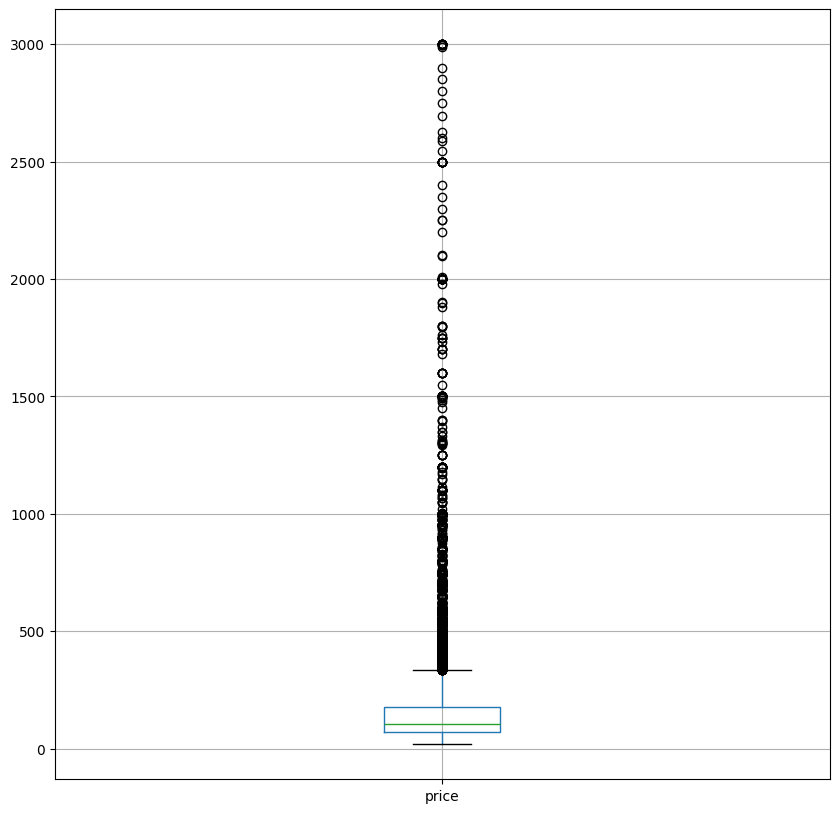

In [779]:
# Gerar boxplot para "price".
data.boxplot(['price'], figsize = (10,10))

Ainda é possível notar as observações relativas aos anúncios de lugares mais luxosos.

Text(0, 0.5, 'Frequência')

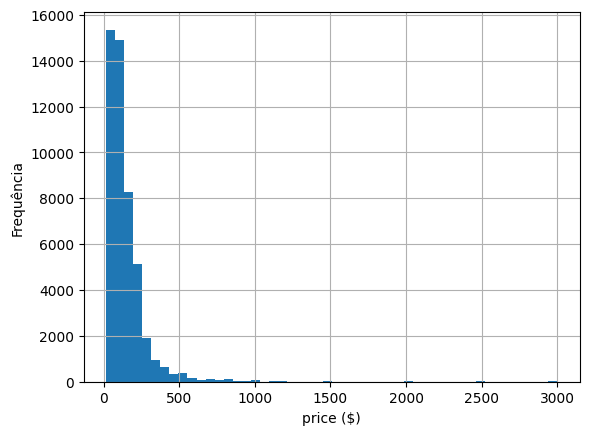

In [780]:
# Gerar histograma para "price".
data['price'].hist(bins = 50)
plt.xlabel('price ($)')
plt.ylabel('Frequência')

A visualização dos dados melhorou significativamente.

<Axes: >

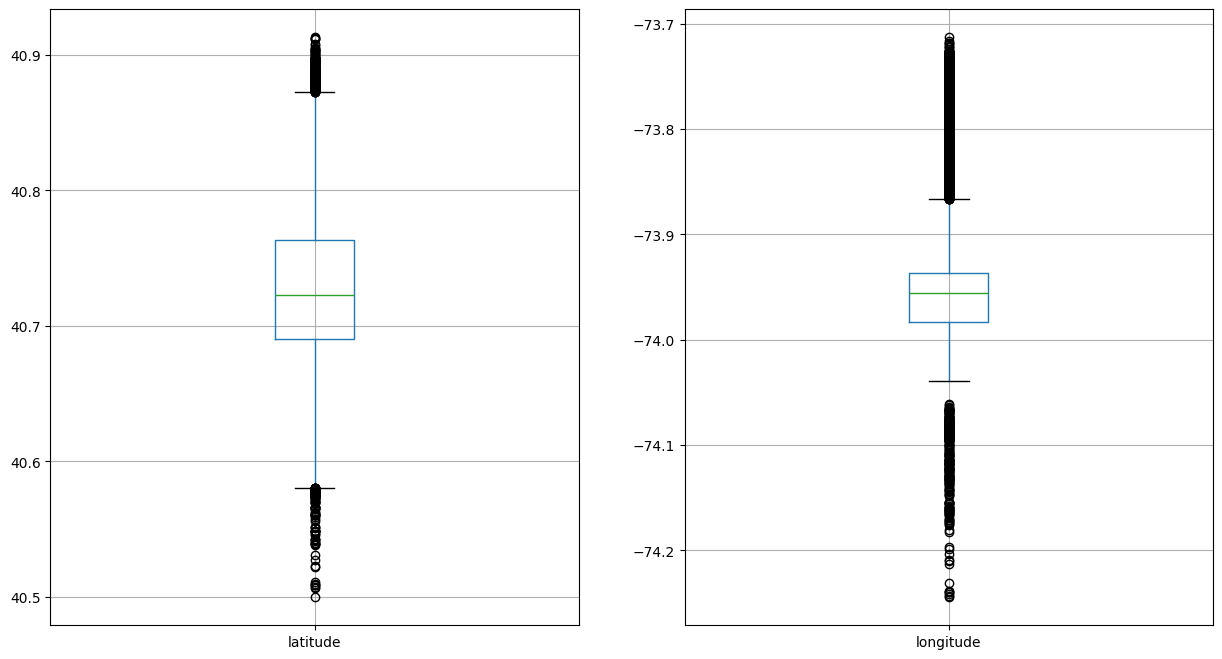

In [781]:
# Gerar boxplot para outras características numéricas de interesse com suspeitas de outliers
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, gráfico 1
data.boxplot(['latitude'])

plt.subplot(1, 2, 2)  # 2 linhas, 2 colunas, gráfico 2
data.boxplot(['longitude'])

array([[<Axes: title={'center': 'calculado_host_listings_count'}>,
        <Axes: title={'center': 'disponibilidade_365'}>,
        <Axes: title={'center': 'latitude'}>],
       [<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'minimo_noites'}>,
        <Axes: title={'center': 'numero_de_reviews'}>],
       [<Axes: title={'center': 'reviews_por_mes'}>, <Axes: >, <Axes: >]],
      dtype=object)

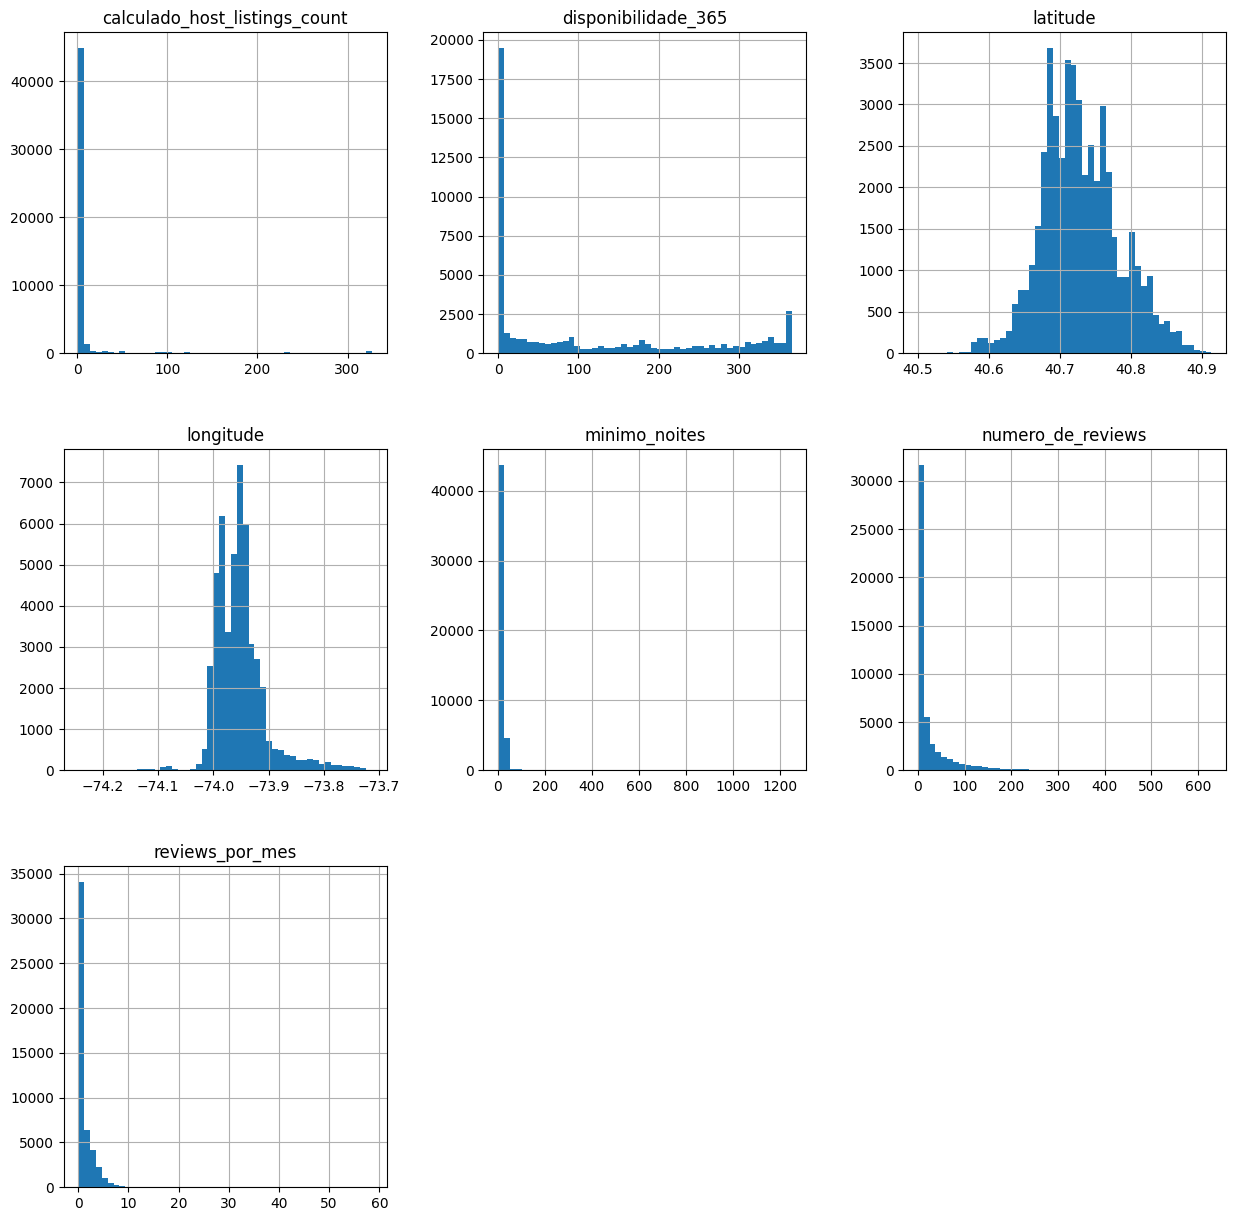

In [782]:
# Desconsiderar a coluna 'price', uma vez que já plotamos seu histograma logo acima.
col_para_hist = data.columns.difference(['price'])

# Gerar Histograma
data[col_para_hist].hist(bins = 50, figsize = (15,15))

Realizando as estatísticas e os plots iniciais (boxplot e histograma), é possível observamos um **resultado mais realístico** (principalmente em `latitute` e `longitude`).

### 2.3.2) Características categóricas

Para analisar características categóricas, uma abordagem comum é utilizar o método `value_counts()` para calcular a contagem de ocorrências de cada categoria única. Isso nos permite entender a distribuição dos dados em diferentes categorias e identificar quais são as categorias mais comuns ou predominantes. 

In [783]:
# Utilizar value_counts() para calcular a contagem de ocorrências de cada categoria única.
data['bairro_group'].value_counts()

bairro_group
Manhattan        21605
Brooklyn         20065
Queens            5656
Bronx             1088
Staten Island      371
Name: count, dtype: int64

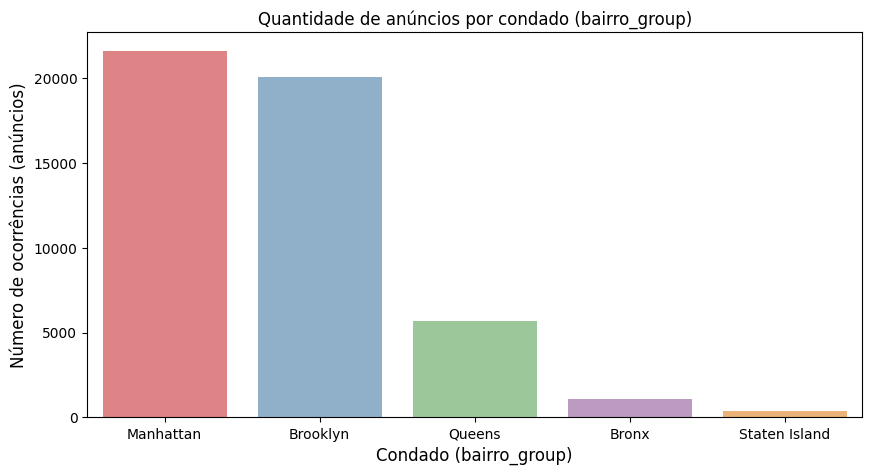

In [784]:
# Gerar barplot para "bairro_group"
bg_count = data['bairro_group'].value_counts()
colors = sns.color_palette("Set1", len(bg_count))
plt.figure(figsize=(10,5))
sns.barplot(x = bg_count.index, y = bg_count.values, alpha = 0.6, hue=bg_count.index, palette=colors, legend=False)
plt.title('Quantidade de anúncios por condado (bairro_group)')
plt.ylabel('Número de ocorrências (anúncios)', fontsize=12)
plt.xlabel('Condado (bairro_group)', fontsize=12)
plt.show()


Nova York é dividida em cinco condados administrativos conhecidos como *boroughs*: Bronx, Brooklyn, Manhattan, Queens e Staten Island A partir desta análise em barplot, podemos interpretar que, quando o assunto é hospedagem, **os condados de Manhattan e Broolyn são aqueles mais procurados pelas pessoas**.

Isso pode ser explicado pelos seguintes motivos:
- Localização e acesso: Manhattan e Brooklyn são *boroughs* populares, conhecidos por sua conveniência, acesso a transporte público, proximidade a empregos e atrações turísticas (Manhattan abriga a famosa *Times Square* e o belo *Central Park*);
- Demografia e cultura: Manhattan é o *borough* mais densamente povoado e é conhecida por sua vida noturna, restaurantes sofisticados e shopping centers de luxo; Brooklyn é o *borough* mais populoso e é associado a uma atmosfera artística, com cena cultural distinta.

Além disso, vale observar que **Staten Island é o borough com menor oferta de locações**. Possivelmente, isso ocorre pelo local ser uma ilha e ser a área mais suburbana de Nova York. O acesso é restrito, sendo feito apenas por balça ou pela Ponte Verrazano-Narrows. Desta maneira, pode existir uma menor procura por locatários, resultando, portanto, em uma menor oferta nesse condado.

In [785]:
data['bairro'].value_counts()

bairro
Williamsburg          3915
Bedford-Stuyvesant    3705
Harlem                2653
Bushwick              2456
Upper West Side       1962
                      ... 
Woodrow                  1
Richmondtown             1
New Dorp                 1
Rossville                1
Willowbrook              1
Name: count, Length: 221, dtype: int64

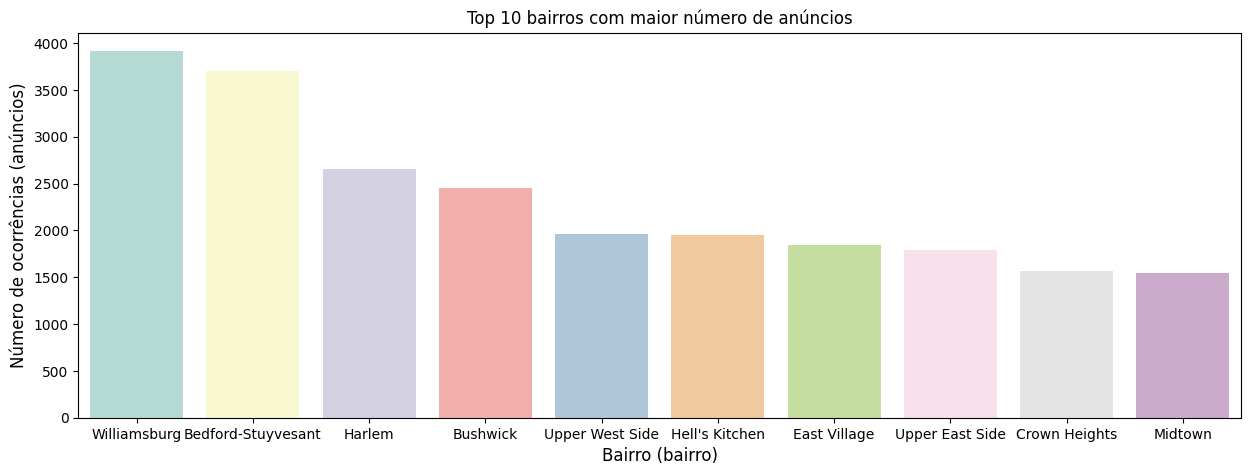

In [786]:
# Gerar barplot para "bairro"
b_count = data['bairro'].value_counts().head(10) # Apenas os 10 bairros com maior número de ocorrências, uma vez que são mais de 200 bairros
colors = sns.color_palette("Set3", len(b_count))
plt.figure(figsize=(15,5))
sns.barplot(x = b_count.index, y = b_count.values, alpha = 0.7, hue=b_count.index, palette=colors, legend=False)
plt.title('Top 10 bairros com maior número de anúncios')
plt.ylabel('Número de ocorrências (anúncios)', fontsize=12)
plt.xlabel('Bairro (bairro)', fontsize=12)
plt.show()


**Todos os bairros do Top 10 estão localizados ou em Manhattan ou no Brooklyn**.

Neste ponto, podemos pensar na seguinte pergunta: ***Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?***

De acordo com nossas análises, observamos que Manhattan e Brooklyn aparentam ser os condados (boroughs) com maior demanda. Fatores sociais como turismo, fácil acesso e cena cultural corroboram essa observação, conforme discutido acima. Por outro lado, observamos que Staten Island é o condado com menos ofertas.

Tanto comprar um apartamento em um condado de alta demanda quanto comprar um apartamento em um condado com menos oferta possuem seus pós e contras.
A decisão sobre onde comprar um apartamento para alugar futuramente pode depender de vários fatores e não há uma resposta única que se aplique a todas as situações. Ambos os cenários têm seus prós e contras, e a escolha também dependerá das metas financeiras da pessoa e do seu perfil de investimento.

Aqui estão algumas considerações para cada cenário:

- **Comprar em uma área com alta demanda**:
  - Potencial de lucro: Condados com alta demanda geralmente têm preços de aluguel mais altos, o que pode resultar em um maior potencial de lucro.
  - Menor tempo de vaga: É mais provável que o seu apartamento seja alugado rapidamente em um condado com alta demanda, reduzindo o tempo de vaga e aumentando o retorno do investimento.
  - Valorização do imóvel: Condados populares tendem a ter uma maior valorização do imóvel ao longo do tempo, o que pode aumentar o valor do seu investimento.

- **Comprar em uma área com menos oferta**:
  - Preços de compra mais baixos: Em áreas com menos demanda, os preços de compra podem ser mais baixos, o que pode resultar em um investimento inicial menor.
  - Menor concorrência: Com menos oferta, pode haver menos concorrência de outros proprietários de aluguel, o que pode facilitar a locação do seu apartamento.
  - Potencial de crescimento: Em alguns casos, bairros emergentes ou em fase de revitalização podem oferecer oportunidades de crescimento a longo prazo, com potencial de valorização do imóvel e aumento da demanda no futuro
 
**Desta maneira, se a pessoa prefere comprar em uma área com alta demanda, a melhor escolha seria Manhattan, seguida de Brooklyn. Contudo, se a pessoa prefere comprar em uma área com menor oferta, a indicação seria Staten Island, seguida de Bronx e Queens.**

In [787]:
data['room_type'].value_counts()

room_type
Entire home/apt    25346
Private room       22291
Shared room         1148
Name: count, dtype: int64

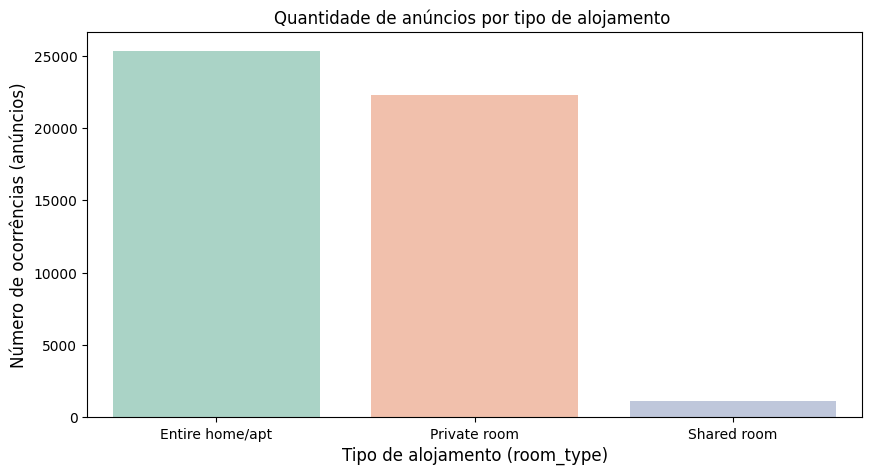

In [788]:
# Gerar barplot para "room_type"
rt_count = data['room_type'].value_counts()
colors = sns.color_palette("Set2", len(rt_count))
plt.figure(figsize=(10,5))
sns.barplot(x = rt_count.index, y = rt_count.values, alpha = 0.6, hue=rt_count.index, palette=colors, legend=False)
plt.title('Quantidade de anúncios por tipo de alojamento ')
plt.ylabel('Número de ocorrências (anúncios)', fontsize=12)
plt.xlabel('Tipo de alojamento (room_type)', fontsize=12)
plt.show()

É visível que existe uma **menor oferta de quartos compartilhados**. Possivelmente, os locatários não possuem tanto interesse neste tipo de quarto. Isso pode ocorrer devido a preferências individuais por privacidade.

**Casa/apartamento inteiro ocorre mais vezes do que quartos privados**. Uma das possíveis explicações poderia ser o desejo do locatário em ter um espaço inteiro para si mesmo, sem ter que dividir espaços comuns (banheiros, cozinha, sala etc) com desconhecidos.

## 2.4) Separação dos conjuntos de teste e treinamento

A separação foi realizada de forma a reservar 20% do conjunto de dados `data` para teste futuro. Os conjuntos de dados foram salvos nos dataframes `train_set` e `test_set`. Essa separação em grupos é necessária para avaliar o desempenho de um modelo de *machine learning* em dados nunca vistos. É desejável que o modelo a ser desenvolvido generalize bem para novos dados, evitando o sobreajuste.

In [789]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, 
                                       test_size=0.2, 
                                       random_state=35)

print("`data` possui {} instâncias, das quais: \n {} são para treinamento \n {} são para testes".
      format(len(data),len(train_set),len(test_set)))

`data` possui 48785 instâncias, das quais: 
 39028 são para treinamento 
 9757 são para testes


## 2.5) Identificação de padrões e relacionamentos nos dados

Vamos buscar por *insights* nos dados de treinamento.

In [790]:
# Criar cópia dos dados de treinamento
train = train_set.copy()

### 2.5.1) Visualização geográfica

<Axes: xlabel='longitude', ylabel='latitude'>

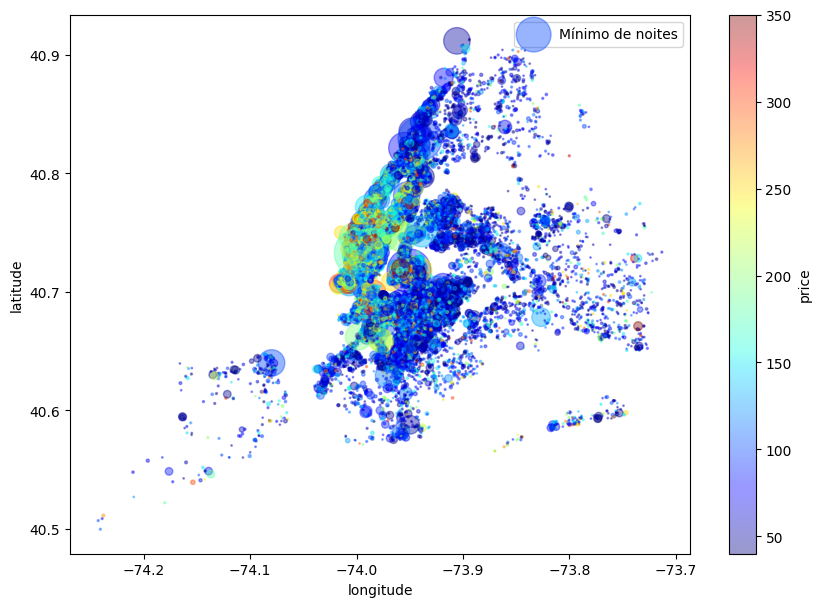

In [791]:
# Definir os limites do intervalo de quartil personalizado
limite_inferior = train['price'].quantile(0.05)  # 5º percentil
limite_superior = train['price'].quantile(0.95)  # 95º percentil

# Filtrar os dados com base no intervalo de quartil personalizado
train_filtrado = train[(train['price'] >= limite_inferior) & (train['price'] <= limite_superior)]

# Plotar o gráfico com os dados filtrados
train_filtrado.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, 
    s=train_filtrado['minimo_noites'], label='Mínimo de noites', figsize=(10,7), 
    c='price', cmap=plt.get_cmap('jet'), colorbar=True)

![Mapa de Nova York](https://imgcap.capturetheatlas.com/wp-content/uploads/2022/12/boroughs-of-new-york-city-map.jpg)

Podemos interpretar que os preços de aluguéis temporários são maiores na região de Manhattan e em parte do Brooklyn. Além disso, Manhattan aparenta ser a região que exige maior quantidade mínima de noites para se realizar uma hospedagem.

Talvez, o número mínimo de noites esteja correlacionado com o preço do aluguel.

É possível visualizar que Staten Island possui pouca oferta de propriedades, possivelmente por conta de ser a região mais suburbana e de acesso limitado.

**Essa análise complementa e corrobora a resposta dada à pergunta feita no item 2.3.2, sobre a indicação do melhor lugar para se comprar uma apartamento para alugar futuramente.**

### 2.5.2) Análise de correlação

In [792]:
numeric_columns = train.select_dtypes(include=['number'])
corr_matrix = numeric_columns.corr()
corr_matrix['price'].sort_values(ascending=False)

price                            1.000000
disponibilidade_365              0.106035
calculado_host_listings_count    0.088996
latitude                         0.050631
minimo_noites                    0.038160
reviews_por_mes                 -0.044839
numero_de_reviews               -0.058162
longitude                       -0.209872
Name: price, dtype: float64

<Axes: >

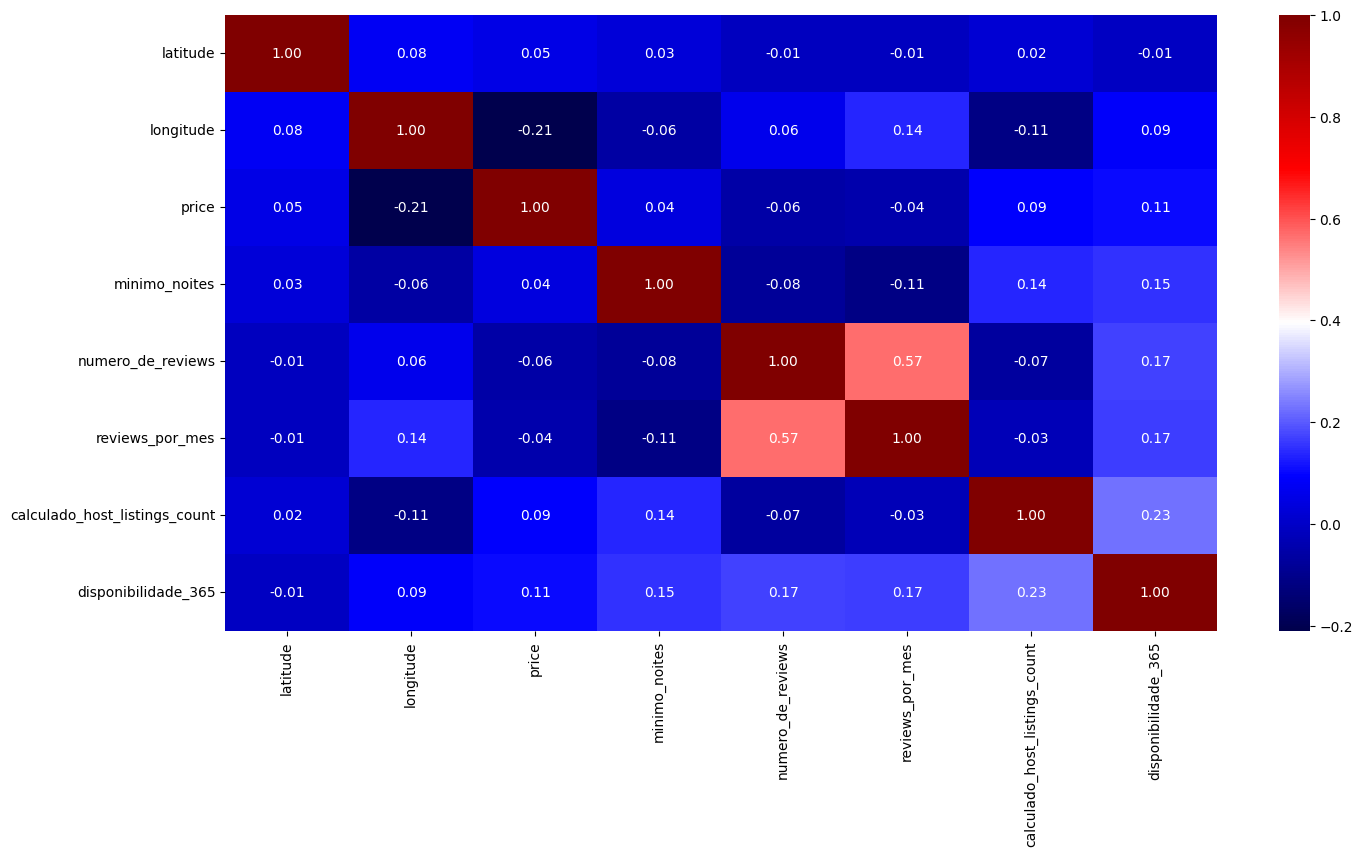

In [793]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.heatmap(corr_matrix, ax=ax, annot=True, fmt=".2f", cmap=plt.get_cmap('seismic'))

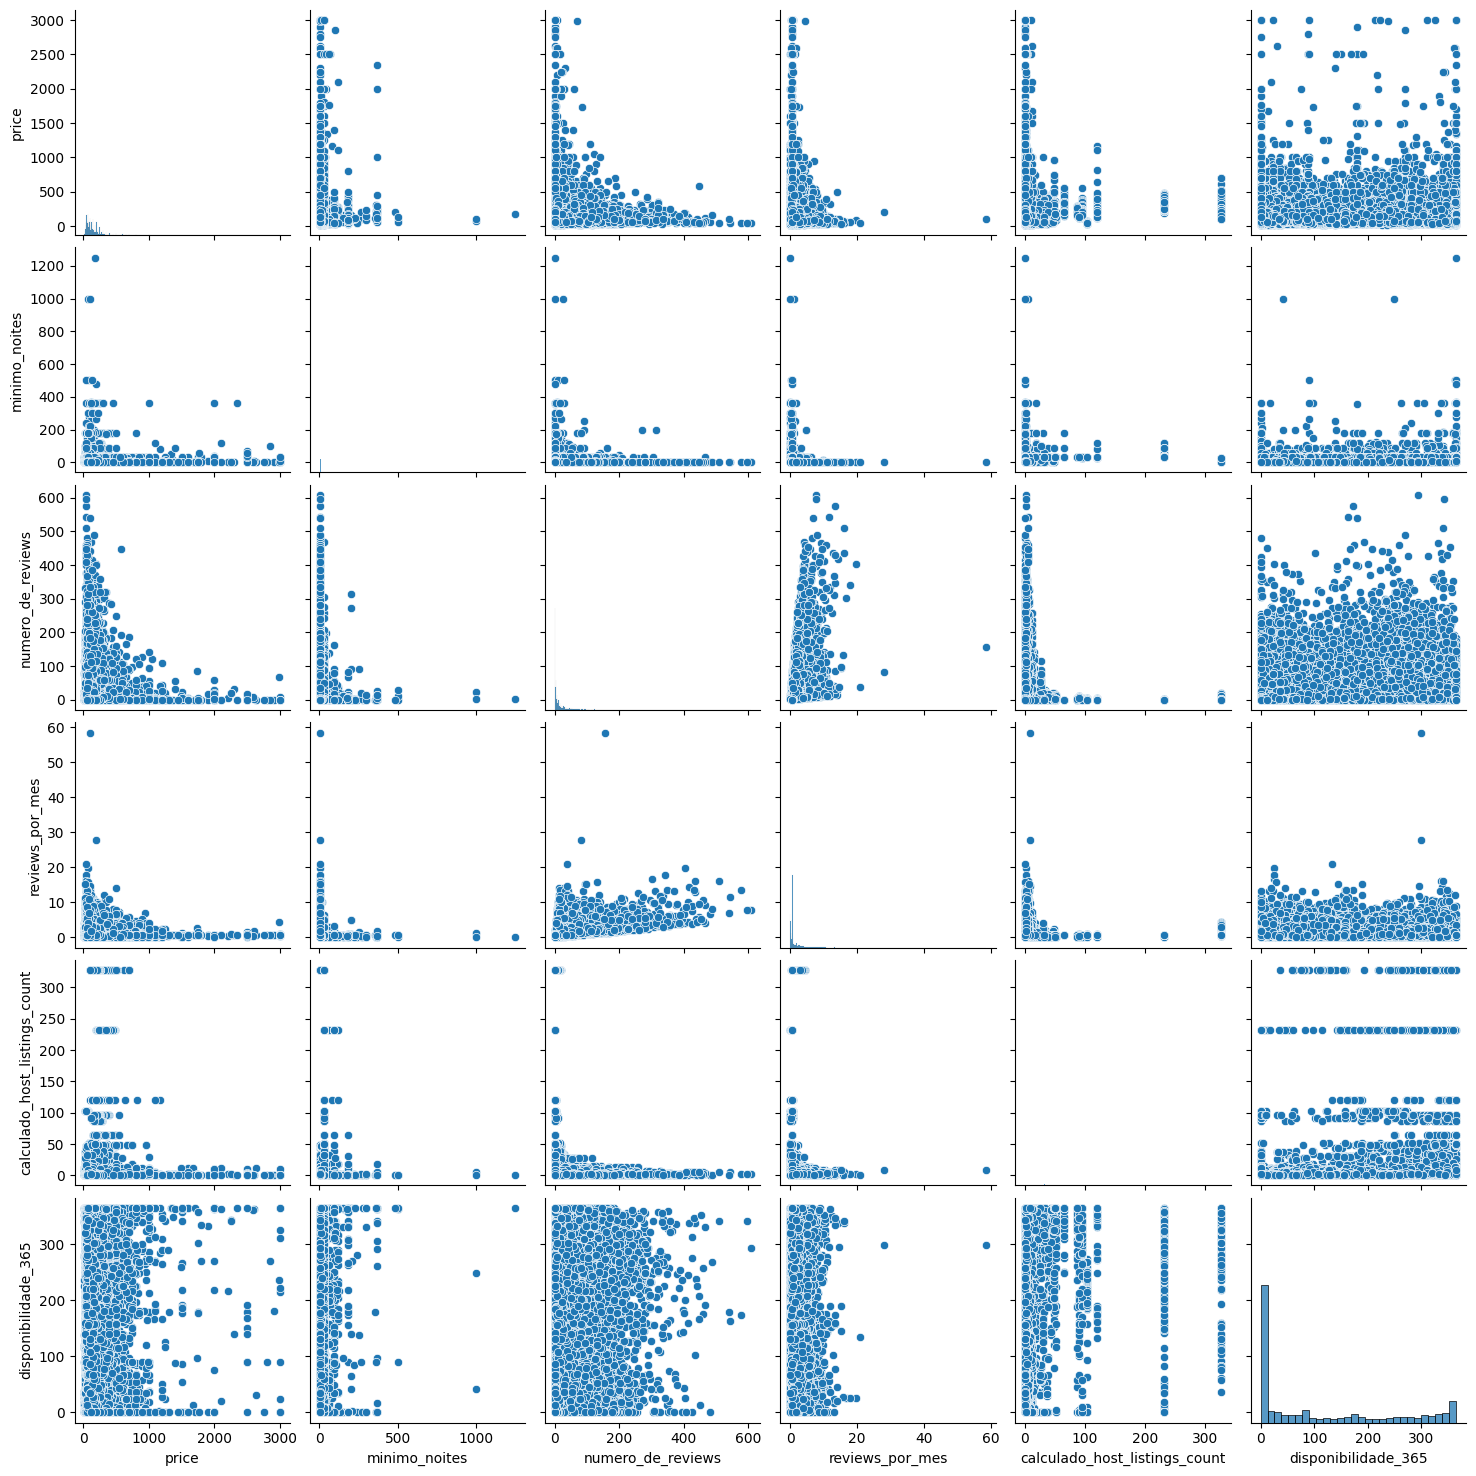

In [794]:
columns = ['price', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']
sns.pairplot(train[columns], diag_kind='hist')

Não foram encontrados coeficientes de correlação fortes com nossa variável de interesse `price`. Aparentemente, as variáveis testadas não têm uma relação linear forte com o preço.

É o momento de refletir sobre o seguinte: ***O número mínimo de noites e a disponibilidade ao longo do ano inteferem no preço?***

**É adequado pensar que o número mínimo de noites provavelmente não interfere no preço, uma vez que essa característica apresentou coeficiente de correlação = 0.038160 (muito próximo de 0, extremamente fraca). Existe uma correlação positiva entre a disponibilidade da propriedade ao longo do ano e o preço, entretanto ela é fraca (coeficiente de correlação = 0.106035). Desta maneira, também é pouco provável que ela impacte no valor do aluguel.**

Vamos considerar uma abordagem de engenharia de características ao aplicar **one-hot enconding** nas variáveis `room_type` e `bairro_group`. Desta maneira, poderemos explorar novas possíveis correlações com variáveis categóricas.

In [795]:
# Aplicar one-hot encoding nas variáveis room_type e bairro_group com valores binários 1 ou 0
train = pd.get_dummies(train, columns=['room_type', 'bairro_group'], prefix=['room', 'bairro'], dtype=int)
train.head()

,nome,bairro,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,room_Entire home/apt,room_Private room,room_Shared room,bairro_Bronx,bairro_Brooklyn,bairro_Manhattan,bairro_Queens,bairro_Staten Island
28631,Spacious & Simple 1BR Apartment for the Holidays!,Inwood,40.86089,-73.92832,100.0,4,0,0.72,1,0,1,0,0,0,0,1,0,0
9430,BROOKLYN HEIGHTS Luxury Harbor View,Brooklyn Heights,40.69470,-73.99304,250.0,7,11,0.24,1,225,1,0,0,0,1,0,0,0
38248,Manhattan apt in the best part of NYC,Washington Heights,40.85042,-73.93649,120.0,5,1,0.16,1,231,1,0,0,0,0,1,0,0
15010,Beautiful Bedroom on Hudson River/Riverside Park,Harlem,40.83342,-73.94949,40.0,1,6,0.16,1,0,0,1,0,0,0,1,0,0
8923,"ONE-OF-A-KIND, EXPOSED-BRICK, 2-BR LOFT w/ VIEWS",Williamsburg,40.71571,-73.96556,85.0,3,93,1.90,1,13,1,0,0,0,1,0,0,0


In [796]:
numeric_columns = train.select_dtypes(include=['number'])
corr_matrix = numeric_columns.corr()
corr_matrix['price'].sort_values(ascending=False)

price                            1.000000
room_Entire home/apt             0.365752
bairro_Manhattan                 0.232184
disponibilidade_365              0.106035
calculado_host_listings_count    0.088996
latitude                         0.050631
minimo_noites                    0.038160
bairro_Staten Island            -0.028601
reviews_por_mes                 -0.044839
bairro_Bronx                    -0.057127
numero_de_reviews               -0.058162
room_Shared room                -0.078862
bairro_Queens                   -0.114087
bairro_Brooklyn                 -0.138091
longitude                       -0.209872
room_Private room               -0.342901
Name: price, dtype: float64

<Axes: >

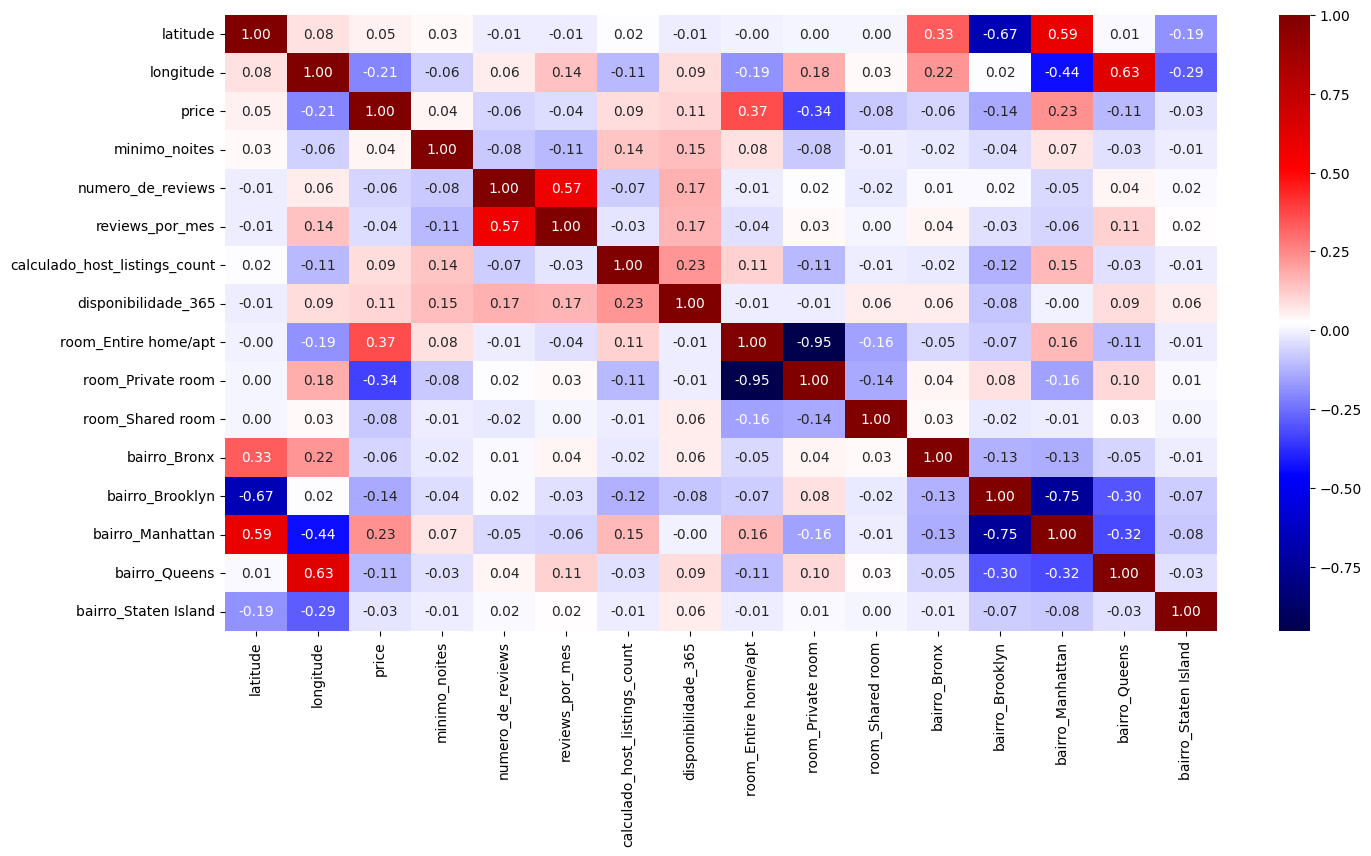

In [797]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.heatmap(corr_matrix, ax=ax, annot=True, fmt=".2f", cmap=plt.get_cmap('seismic'))

Começaram a surgir **algumas variáveis que se correlacionam de maneira mais interessante com a variável `price`**. **`room_Entire home/apt` aparenta ser a variável com maior impacto no em `price`**. É coerente pensar que propriedades que disponibilizam todo o espaço para o inquilino sejam mais caras, uma vez que oferecem maior privacidade e conforto ao usuário. Da mesma forma, propriedades que disponibilizam apenas um quarto privado ao inquilino tendem a ter um valor de aluguel mais baixo, uma vez que oferecem menos espaço e privacidade. 

Manhattan aparece como o condado com correlação positiva razoável em relação a `price`, reforçando o alto custo de vida desse lugar. Brooklyn aparece com fraco, mas presente, coeficiente de correlação negativo, sugerindo, talvez, que os preços de aluguel seriam mais baratos do que em Manhattan.

Vamos tentar criar mais algumas variáveis. Desta vez, **investigaremos as palavras utilizadas nos nomes dos anúncios mais caros**. Aproveitaremos, também, para responder a seguinte pergunta: ***Existe algum padrão no texto do nome do local para lugares de mais alto valor?***

In [798]:
import string
import nltk
from nltk.corpus import stopwords

# Baixar a lista de stopwords do NLTK
nltk.download('stopwords')

# Obter a lista de stopwords em inglês
stop_words = set(stopwords.words('english'))

# Função para pré-processar os nomes dos anúncios
def preprocessar_nome(nome):
    # Remover pontuações
    nome_sem_pontuacao = ''.join(caracter for caracter in nome if caracter not in string.punctuation)
    # Remover caracteres/números soltos
    nome_sem_caracteres_soltos = ' '.join(palavra for palavra in nome_sem_pontuacao.split() if len(palavra) > 1)
    # Remover stopwords
    nome_sem_stopwords = ' '.join(palavra for palavra in nome_sem_caracteres_soltos.split() if palavra.lower() not in stop_words)
    return nome_sem_stopwords

# Selecionar os anúncios com os maiores valores de 'price'
anuncios_precos_altos = train[train['price'] > train['price'].quantile(0.95)]

# Aplicar pré-processamento aos nomes dos anúncios
anuncios_precos_altos['nome_limpo'] = anuncios_precos_altos['nome'].apply(preprocessar_nome)

# Concatenar todos os nomes de anúncios pré-processados em uma única string
texto_completo = ' '.join(anuncios_precos_altos['nome_limpo'])

# Dividir a string em palavras individuais
palavras = texto_completo.split()

# Criar uma série com a contagem de cada palavra após o pré-processamento
contagem_palavras = pd.Series(palavras).value_counts()

# Imprimir as 10 palavras mais comuns após o pré-processamento
print(contagem_palavras.head(10))

Luxury       173
Bedroom      157
Loft         143
Manhattan    137
NYC          131
Park         128
Village      124
Apartment    124
Apt          117
Central      110
Name: count, dtype: int64


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\igorg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\igorg\AppData\Local\Temp\ipykernel_17092\1888759557.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Respondendo à pergunta: 

**Aparentemente, existe. "Luxury", "Bedroom", "Loft", "Manhattan", "NYC", "Park", "Village", "Apartment", "Apt" e "Central" são as palavras que mais aparecem nos nomes dos anúncios com maiores preços de aluguel. Essa observação é coerente, uma vez que essas palavras estão ou relacionada a locais valorizados da cidade, ou a coisas que valorizam o valor da propriedade, ou, ainda, ao estilo de vida de alto padrão.** 

In [799]:
# Selecionar as 10 palavras mais comuns após o pré-processamento
top_palavras = contagem_palavras.head(10).index

# Criar colunas one-hot binárias numéricas para as palavras selecionadas
for palavra in top_palavras:
    train[palavra] = train['nome'].str.contains(palavra).astype(int)

In [800]:
numeric_columns = train.select_dtypes(include=['number'])
corr_matrix = numeric_columns.corr()
corr_matrix['price'].sort_values(ascending=False)

price                            1.000000
room_Entire home/apt             0.365752
bairro_Manhattan                 0.232184
Luxury                           0.109055
disponibilidade_365              0.106035
calculado_host_listings_count    0.088996
Loft                             0.077316
Village                          0.072461
latitude                         0.050631
Central                          0.038455
minimo_noites                    0.038160
Apt                              0.026357
Park                             0.023749
NYC                              0.023697
Apartment                        0.009964
Bedroom                          0.001125
Manhattan                       -0.006741
bairro_Staten Island            -0.028601
reviews_por_mes                 -0.044839
bairro_Bronx                    -0.057127
numero_de_reviews               -0.058162
room_Shared room                -0.078862
bairro_Queens                   -0.114087
bairro_Brooklyn                 -0

<Axes: >

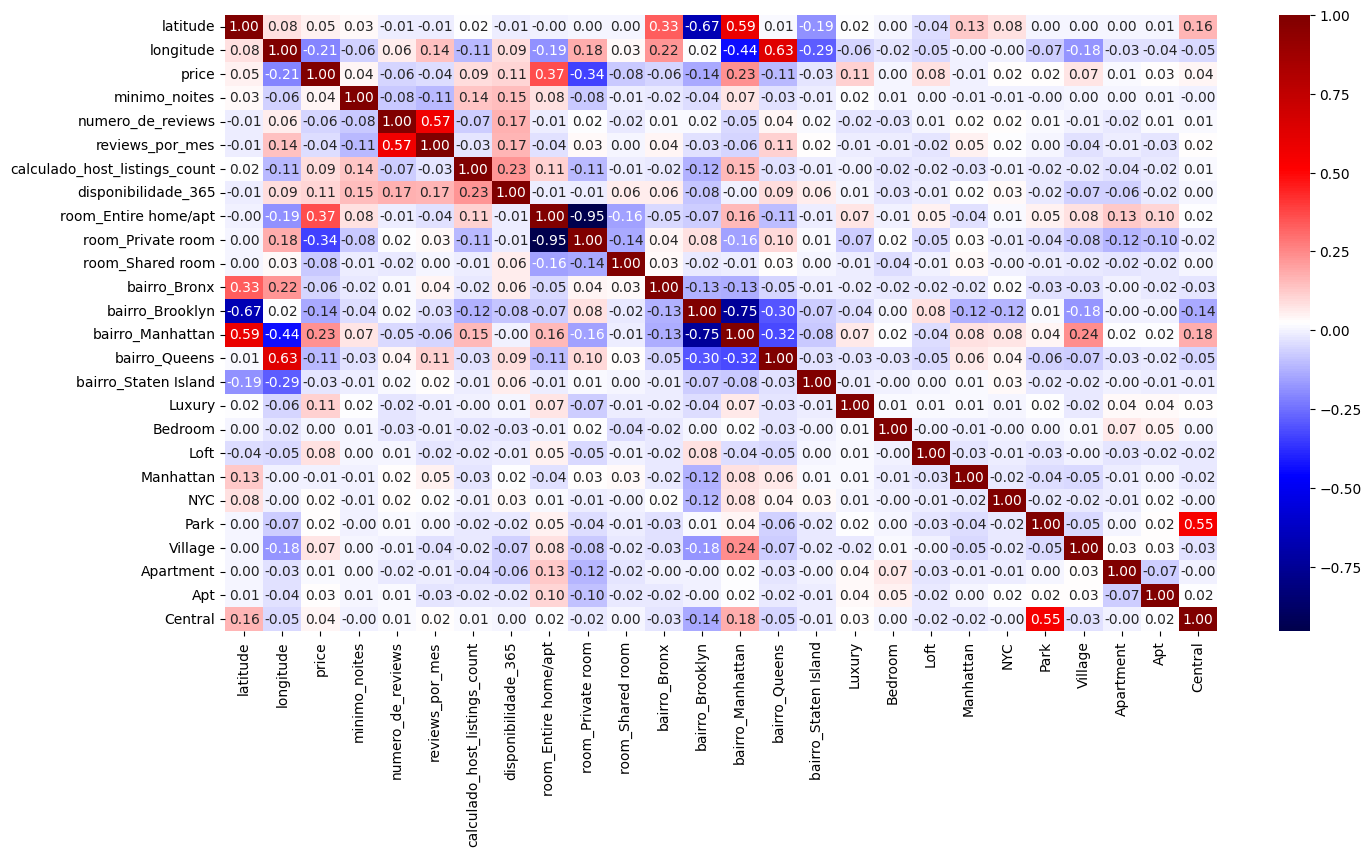

In [801]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.heatmap(corr_matrix, ax=ax, annot=True, fmt=".2f", cmap=plt.get_cmap('seismic'))

A única palavra que aparenta estar razoavelmente correlacionada com `price` é "Luxury". Faz sentido ser uma correlação positiva, pois imóveis de luxo costumam ter aluguéis mais caros.

De qualquer forma, podemos observar que **nossa abordagem de criar novas características derivadas das existentes mostrou-se pertinente**. O processo de *one-hot encoding* em `room_type` e `bairro_group` gerou as características que apresentam os mais fortes coeficientes de correlação com `price`. A criação de características baseadas em palavras de `nome` possibilitou a observação de que a palavra "Luxury", quando incluída nos anúncios, pode estar relacionada com maiores preços de aluguel.

In [802]:
# DataFrame 'train' após a criação de novas características.
train.head()

,nome,bairro,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,...,Luxury,Bedroom,Loft,Manhattan,NYC,Park,Village,Apartment,Apt,Central
28631,Spacious & Simple 1BR Apartment for the Holidays!,Inwood,40.86089,-73.92832,100.0,4,0,0.72,1,0,...,0,0,0,0,0,0,0,1,0,0
9430,BROOKLYN HEIGHTS Luxury Harbor View,Brooklyn Heights,40.69470,-73.99304,250.0,7,11,0.24,1,225,...,1,0,0,0,0,0,0,0,0,0
38248,Manhattan apt in the best part of NYC,Washington Heights,40.85042,-73.93649,120.0,5,1,0.16,1,231,...,0,0,0,1,1,0,0,0,0,0
15010,Beautiful Bedroom on Hudson River/Riverside Park,Harlem,40.83342,-73.94949,40.0,1,6,0.16,1,0,...,0,1,0,0,0,1,0,0,0,0
8923,"ONE-OF-A-KIND, EXPOSED-BRICK, 2-BR LOFT w/ VIEWS",Williamsburg,40.71571,-73.96556,85.0,3,93,1.90,1,13,...,0,0,0,0,0,0,0,0,0,0


In [803]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39028 entries, 28631 to 5849
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   nome                           39028 non-null  object 
 1   bairro                         39028 non-null  object 
 2   latitude                       39028 non-null  float64
 3   longitude                      39028 non-null  float64
 4   price                          39028 non-null  float64
 5   minimo_noites                  39028 non-null  int64  
 6   numero_de_reviews              39028 non-null  int64  
 7   reviews_por_mes                39028 non-null  float64
 8   calculado_host_listings_count  39028 non-null  int64  
 9   disponibilidade_365            39028 non-null  int64  
 10  room_Entire home/apt           39028 non-null  int32  
 11  room_Private room              39028 non-null  int32  
 12  room_Shared room               39028 non-null  i

### 2.5.3) Escolha de características

Após a exploração dos dados realizada, vamos selecionar as características a serem consideradas no modelo. É importante destacar que criamos características novas e devemos avaliar se elas devem ou não continuar no conjunto.

Nesta etapa, levaremos em consideração o **valor teórico e prático** das características para a resolução do problema.

Desta maneira, considerando os baixos valores encontrados na análise de correleção, **removeremos as características `Bedroom`, `Loft`, `Manhattan`, `NYC`, `Park`, `Village`, `Apartment`, `Apt` e `Central`**. Manteremos a característica `Luxury`, pois seu coeficiente de correlação é maior do que os demais e ela possui maior valor teórico.

Manteremos no conjunto as características criadas a partir de *out-hot encoding* de `room_type` e `bairro_group`, pois elas apresentaram coeficientes de correlação interessantes e possuem alto valor teórico.

A característica **`nome` será removida**, pois já extraímos valor das informações nela contida e sintetizamos na característica `Luxury`.

A característica **`bairro` também será removida**, pois não há como aplicar *one-hot encoding* a ela devido à sua grande quantidade de valores únicos (são mais de 200 bairros). Além disso, a característica geradas a partir de *one-hot encoding* de `bairro_group` (`bairro_Bronx`, `bairro_Brooklyn`, `bairro_Manhattan`, `bairro_Queens`, `bairro_Staten Island`) suprem, de maneira generalizada, as informações contidas em `bairro`.

Aparentemente, o restante das características numéricas podem apresentar alto valor teórico e, por isso, as manteremos no conjunto.

In [804]:
# Remover características desnecessárias
colunas_para_remover = ['Bedroom', 'Loft', 'Manhattan', 'NYC', 'Park', 'Village', 'Apartment', 'Apt', 'Central', 'nome', 'bairro']
train = train.drop(columns=colunas_para_remover)

# DataFrame 'train' após a remoção das citadas características.
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39028 entries, 28631 to 5849
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   latitude                       39028 non-null  float64
 1   longitude                      39028 non-null  float64
 2   price                          39028 non-null  float64
 3   minimo_noites                  39028 non-null  int64  
 4   numero_de_reviews              39028 non-null  int64  
 5   reviews_por_mes                39028 non-null  float64
 6   calculado_host_listings_count  39028 non-null  int64  
 7   disponibilidade_365            39028 non-null  int64  
 8   room_Entire home/apt           39028 non-null  int32  
 9   room_Private room              39028 non-null  int32  
 10  room_Shared room               39028 non-null  int32  
 11  bairro_Bronx                   39028 non-null  int32  
 12  bairro_Brooklyn                39028 non-null  i

# 3) Desenvolvimento do modelo de previsão de preços

O objetivo do nosso modelo é prever o preço (variável contínua) de aluguel temporário com base em características do anúncio. Portanto, **o problema que estamos resolvendo é uma regressão**. Em problemas desse tipo, o objetivo é prever um valor contínuo com base em um conjunto de características ou variáveis independentes.

Em outras palavras, não estamos tentando classificar os aluguéis em categorias discretas, como "alto" ou "baixo", mas sim prever um valor numérico específico para o preço do aluguel.

A limpeza dos dados já foi feita no tópico 2.2 e a escolha das características de interesse foi realizada no tópico 2.5.3. Desta maneira, vamos criar o vetor de características **X** e os valores esperados **Y**. Para ter certeza, vamos confirmar também que não há nenhum valor faltanto no vetor de entrada **X**.

In [805]:
# Criar vetores sem afetar train
train_X = train.drop("price", axis=1)

# Copiar a label (y) do train
train_y = train.price.copy()

# Contar a quantidade de valores nulos
train_X.isnull().sum()

latitude                         0
longitude                        0
minimo_noites                    0
numero_de_reviews                0
reviews_por_mes                  0
calculado_host_listings_count    0
disponibilidade_365              0
room_Entire home/apt             0
room_Private room                0
room_Shared room                 0
bairro_Bronx                     0
bairro_Brooklyn                  0
bairro_Manhattan                 0
bairro_Queens                    0
bairro_Staten Island             0
Luxury                           0
dtype: int64

## 3.1) Selecionar e treinar o modelo

Temos nossos dados de treinamento preparados. Então, podemos treinar o nosso modelo usando algoritmo de Machine Learning. Inicaremos com a **Regressão Linear**.

### 3.1.1) Regressão Linear

In [806]:
from sklearn.linear_model import LinearRegression

# Criar um modelo de regressão linear
lin_reg = LinearRegression()

# Ajustar o modelo
lin_reg.fit(train_X, train_y)

# Fazer previsões
predictions = lin_reg.predict(train_X)

# Criar um DataFrame com os valores reais e previstos
results_df = pd.DataFrame({'Real': train_y, 'Predicted': predictions})
print(results_df)

        Real   Predicted
28631  100.0  175.978662
9430   250.0  280.911514
38248  120.0  219.941180
15010   40.0   90.054432
8923    85.0  144.058407
...      ...         ...
15840   60.0   74.859821
19427   99.0  104.171893
48269   98.0  149.657450
42003   51.0   85.599782
5849   125.0  133.875269

[39028 rows x 2 columns]


O modelo funciona. Agora, vamos avaliá-lo com **Raíz do Erro Quadrático Médio (RMSE)**.

A Raiz do Erro Quadrático Médio (RMSE) é uma métrica comum para avaliar a performance de modelos de regressão. Ela calcula a raiz quadrada da média dos quadrados dos erros entre os valores observados e os valores previstos pelo modelo.

A principal vantagem do RMSE é que ele **fornece uma medida da dispersão dos erros, ou seja, quão longe, em média, as previsões do modelo estão dos valores reais**. Algumas **vantagens** adicionais do RMSE incluem:

 - **Interpretação intuitiva**: O RMSE tem a **mesma unidade que a variável de destino**, o que facilita a interpretação. Por exemplo, se estivermos prevendo preços de imóveis em dólares, o RMSE será em dólares também.
   
 - **Penalização de grandes erros**: Como os erros são elevados ao quadrado antes de serem calculados, o RMSE penaliza fortemente os grandes erros. Isso significa que o RMSE é sensível a grandes discrepâncias entre os valores reais e previstos.
   
 - **Diferença em relação à média**: O RMSE pode ser comparado com a variabilidade dos dados, geralmente representada pela média dos valores reais. Isso ajuda a avaliar se o modelo está melhorando as previsões em relação a uma estimativa ingênua, como prever sempre a média dos valores reais.

In [807]:
from sklearn.metrics import mean_squared_error

# Usar o modelo para fazer predição
price_predictions = lin_reg.predict(train_X)

# Métrica de avaliação de performance (RMSE)
lin_mse = mean_squared_error(train_y, price_predictions)
lin_rmse = np.sqrt(lin_mse)
print("RMSE de Regressão Linear: {}".format(lin_rmse))

RMSE de Regressão Linear: 142.46841708960335


Apesar dos valores de aluguéis irem de \\$ 18,00 a \\$ 3.000,00, o erro médio de **142.47** é muito grande, uma vez que a mediana dos valores é \\$ 106,00. O resultado mostra que, provavelmente, o modelo está ***underfitting*** os dados. Portanto, podemos selecionar outro modelo mais aplicável ao problema, como ***Decision Tree*** ou ***Random Forest***.

### 3.1.2) *Decision Tree*

In [808]:
from sklearn.tree import DecisionTreeRegressor

# Criar modelo de Decision Tree
tree_reg = DecisionTreeRegressor()
tree_reg.fit(train_X, train_y)

# Fazer predições
tree_housing_predictions = tree_reg.predict(train_X)

# Criar um DataFrame com os valores reais e previstos
results_df = pd.DataFrame({'Real': train_y, 'Predicted': tree_housing_predictions})
print(results_df)

        Real  Predicted
28631  100.0      100.0
9430   250.0      250.0
38248  120.0      120.0
15010   40.0       40.0
8923    85.0       85.0
...      ...        ...
15840   60.0       60.0
19427   99.0       99.0
48269   98.0       98.0
42003   51.0       51.0
5849   125.0      125.0

[39028 rows x 2 columns]


In [809]:
# Métrica de avaliação de performance (RMSE)
tree_mse = mean_squared_error(train_y,tree_housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print("Decision Tree RMSE: {}".format(tree_rmse))

Decision Tree RMSE: 0.17896448637485884


O erro está muito próximo de zero. Provavelmente, o modelo está ***overfitting*** os dados.

### 3.1.3) *Random Forest*

In [810]:
from sklearn.ensemble import RandomForestRegressor

# Criar modelo Random Forest
forest_reg = RandomForestRegressor()
forest_reg.fit(train_X, train_y)

# Fazer predições
rand_housing_predictions = forest_reg.predict(train_X)

# Criar um DataFrame com os valores reais e previstos
results_df = pd.DataFrame({'Real': train_y, 'Predicted': rand_housing_predictions})
print(results_df)

        Real  Predicted
28631  100.0      98.41
9430   250.0     250.35
38248  120.0     142.91
15010   40.0      49.30
8923    85.0     120.23
...      ...        ...
15840   60.0      61.56
19427   99.0      95.70
48269   98.0     105.37
42003   51.0      61.19
5849   125.0     118.57

[39028 rows x 2 columns]


In [811]:
# Métrica de avaliação de performance (RMSE)
forest_mse = mean_squared_error(train_y, rand_housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print("Random Forest RMSE: {}".format(forest_rmse))

Random Forest RMSE: 50.5351944682228


Em comparação com o RMSE da Regressão Linear, o valor reduziu significativamente. Entretanto, ele ainda é alto.

## 3.2) Validar modelo

Validar o modelo envolve avaliar seu desempenho em dados não vistos para garantir sua capacidade de generalização. Suas utilidades incluem avaliar o desempenho, detectar overfitting, comparar modelos, embasar decisões e fornecer confiança na utilização do modelo em situações reais.

### 3.2.1) Validação cruzada (*Cross-Validation*)

A validação cruzada é uma técnica fundamental em aprendizado de máquina para avaliar a capacidade de generalização de um modelo em dados não vistos

In [812]:
from sklearn.model_selection import cross_val_score

# Modelos
tree_reg = DecisionTreeRegressor()
lin_reg = LinearRegression()
forest_reg = RandomForestRegressor()

# Scores com cross_validaton
scores = cross_val_score(tree_reg, 
                         train_X, 
                         train_y,
                         scoring="neg_mean_squared_error",
                         cv=10)

lin_scores = cross_val_score(lin_reg, 
                             train_X, 
                             train_y,
                             scoring="neg_mean_squared_error", 
                             cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

forest_scores = cross_val_score(forest_reg,
                                train_X, 
                                train_y,
                                scoring="neg_mean_squared_error", 
                                cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)


# Resultados
rmse_scores = np.sqrt(-scores)

def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

print("\nDecision Tree Results:\n")
display_scores(rmse_scores)

print("\n\nRandom Forest Results:\n")
display_scores(forest_rmse_scores)

print("\n\nLinear Regression Results:\n")
display_scores(lin_rmse_scores)


Decision Tree Results:

Scores: [192.04183892 184.87587363 188.57691775 180.50077733 190.9507256
 170.24155421 189.80947201 199.0302624  197.17281354 162.06663461]
Mean: 185.52668699966767
Standard deviation: 11.077838393983074


Random Forest Results:

Scores: [120.93274914 147.09265257 134.98581569 134.15261818 137.15273057
 135.05592537 132.24189405 159.87894973 131.25789966 115.6997019 ]
Mean: 134.84509368728627
Standard deviation: 11.671801817920288


Linear Regression Results:

Scores: [132.57797502 155.03165729 141.47222965 142.78977116 141.68318075
 142.10848251 145.4697426  165.93579505 135.89325138 117.19427555]
Mean: 142.01563609551425
Standard deviation: 12.235964885303957


Os modelos apresetaram resultados mais semelhantes. *Random Forest* ainda é o que encontra menor valor de RMSE.

### 3.2.2) Testar múltiplos hiperparâmetros

Testar múltiplos hiperparâmetros envolve explorar diferentes combinações de valores para os parâmetros de um modelo de machine learning com o objetivo de encontrar a combinação que otimize o desempenho do modelo em dados de validação. A utilidade desse procedimento está em encontrar a configuração ideal do modelo, melhorando sua precisão e generalização para novos dados. Isso ajuda a evitar *overfitting* e a obter um modelo mais robusto e eficaz.

Para isso, podemos utilizar GridSearchCV do `scikit-lean`. Vamos testar vários parâmetros do modelo ***Random Forest***, uma vez que ele apresentou o melhor desempenho até então.

In [813]:
from sklearn.model_selection import GridSearchCV

# hyperparameters values
# param_grid[0] - 12 combinations
# param_grid[1] - 6 combinations
param_grid = [{'n_estimators': [3, 10, 30], 
                    'max_features': [2, 4, 6, 8]
                    },
                    {'bootstrap': [False], 
                     'n_estimators': [3, 10],
                     'max_features': [2, 3, 4]
                    }
                  ]

# run the grid search with cross validation
# (12 + 6) x 5 = 90 combinations
grid_search = GridSearchCV(forest_reg, 
                           param_grid, 
                           cv=5,
                           scoring='neg_mean_squared_error')

# see 90 combinations!!!
# it may take quite a long time
grid_search.fit(train_X, train_y)

# when gridsearch is done you can get the best combination of parameters
print("Best Parametes:\n")
print(grid_search.best_params_)

print("Best Score:\n")
print(grid_search.best_score_)
#grid_search.cv_results_['mean_test_score'].max()

Best Parametes:

{'max_features': 4, 'n_estimators': 30}
Best Score:

-18047.559552569513


## 3.3) Escolher o melhor modelo

Considerando os resultados obtidos anteriormente, escolheremos ***Random Forest*** como o melhor modelo. Ainda, o melhor estimador está salvo em `grid_search.best_params_`.

Abaixo, os prós e os contras de utilizar ***Random Forest*** como modelo:

- **Prós**:
  - Alta precisão: Random Forest geralmente oferece uma precisão robusta em uma variedade de conjuntos de dados e problemas, mesmo sem ajuste fino.
  - Robusto contra overfitting: Devido à sua natureza de construir múltiplas árvores de decisão e média de seus resultados, o Random Forest é menos propenso a overfitting em comparação com uma única árvore de decisão.
  - Lida bem com dados desbalanceados: Random Forest pode lidar bem com conjuntos de dados desbalanceados, onde uma classe é muito mais predominante do que outras.
  - Capacidade de lidar com grandes conjuntos de dados: Pode ser eficiente em termos de tempo de treinamento, mesmo em conjuntos de dados grandes, devido à sua capacidade de paralelizar o treinamento em várias árvores.
  - Lida com dados faltantes: Pode lidar naturalmente com valores ausentes sem a necessidade de pré-processamento extensivo.

- **Contras**:
  - Difícil de interpretar: O modelo Random Forest pode ser mais difícil de interpretar do que modelos lineares ou até mesmo árvores de decisão individuais, especialmente quando há muitas árvores na floresta.
  - Tendência a overfitting com hiperparâmetros inadequados: Embora seja robusto contra overfitting em comparação com árvores de decisão únicas, o Random Forest ainda pode sofrer de overfitting se os hiperparâmetros não forem ajustados adequadamente.
  - Pode ser lento para prever: Embora o treinamento do Random Forest possa ser eficiente, a previsão pode ser mais lenta do que modelos mais simples devido à necessidade de fazer previsões para várias árvores e combinar os resultados.
  - Não tão eficaz com dados esparsos: Pode não funcionar tão bem com dados extremamente esparsos ou de alta dimensionalidade, onde outras técnicas como modelos lineares ou redes neurais podem ser mais adequadas.

In [814]:
print(grid_search.best_estimator_)

RandomForestRegressor(max_features=4, n_estimators=30)


Agora, iremos chamar os objetos do módulo scikit-learn responsável em armazenar os valores médios dos atributos, para caso exista a necessidade de substituir o valores faltando no futuro. Além disso, teremos o registro constante da mediana que está sendo utilizada na subtituição de dados faltando.

In [815]:
from sklearn.impute import SimpleImputer

# Criar instância de imputer
imputer = SimpleImputer(strategy="median")

# Criar cópia dos dados apenas com os valores numéricos, uma vez que mediana só pode ser obtida a partir de números
train_X_num = train_X.select_dtypes(include=['number'])

# Ajustar a instância do imputer aos dados de treinamento:
imputer.fit(train_X_num)

# Podemos usar este imputer "treinado" para transformar o conjunto de treinamento, substituindo os valores ausentes pelas medianas aprendidas
train_X_num_array = imputer.transform(train_X_num)

# O resultado é um array NumPy simples contendo as características transformadas. Para colocar de volta em um DataFrame do Pandas, fazer o seguinte:
train_X_num_df = pd.DataFrame(train_X_num_array, columns=train_X_num.columns)

imputer.statistics_

array([ 40.72307, -73.95569,   3.     ,   5.     ,   0.72   ,   1.     ,
        45.     ,   1.     ,   0.     ,   0.     ,   0.     ,   0.     ,
         0.     ,   0.     ,   0.     ,   0.     ])

In [816]:
train_X_num_df.describe()

,latitude,longitude,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,room_Entire home/apt,room_Private room,room_Shared room,bairro_Bronx,bairro_Brooklyn,bairro_Manhattan,bairro_Queens,bairro_Staten Island,Luxury
count,39028.000000,39028.000000,39028.000000,39028.000000,39028.000000,39028.000000,39028.000000,39028.000000,39028.000000,39028.000000,39028.000000,39028.000000,39028.000000,39028.000000,39028.000000,39028.000000
mean,40.728976,-73.952134,6.956954,23.298376,1.243047,7.181306,112.977683,0.518141,0.458568,0.023291,0.022215,0.410193,0.443989,0.115968,0.007636,0.026776
std,0.054431,0.046293,19.541245,44.564145,1.538650,33.003096,131.762480,0.499677,0.498287,0.150828,0.147383,0.491875,0.496859,0.320191,0.087048,0.161429
min,40.499790,-74.242850,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.690300,-73.983130,1.000000,1.000000,0.280000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.723070,-73.955690,3.000000,5.000000,0.720000,1.000000,45.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,40.763100,-73.936380,5.000000,24.000000,1.580000,2.000000,229.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,40.913060,-73.712990,1250.000000,607.000000,58.500000,327.000000,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Aplicamos a substituição dos valores ausentes utilizando a mediana armazenada no imputer. Embora não haja valores ausentes neste caso, essa abordagem automatizará essa escolha em conjuntos de dados futuros.

## 3.4) Avaliar os atributos

Com o modelo final em mãos, podemos avaliar a importância dos atributos e, possivelmente, retirar alguns menos importantes. A criação de modelos de *Machine Learning* é um processo cíclico, ou seja, sempre pode ser melhorado.

In [817]:
# Obtém as pontuações de importância dos atributos e exibe de maneira ordenada, ao lado do nome do atributo
feature_importances = grid_search.best_estimator_.feature_importances_
nomes_atributos = train_X.columns
sorted(zip(feature_importances, nomes_atributos), reverse=True)

[(0.2355703511541566, 'longitude'),
 (0.20124077527622625, 'latitude'),
 (0.12970451371225314, 'disponibilidade_365'),
 (0.08450782479802757, 'minimo_noites'),
 (0.07374564862784282, 'reviews_por_mes'),
 (0.06655078295594068, 'numero_de_reviews'),
 (0.06560693007432161, 'room_Entire home/apt'),
 (0.053381173420079614, 'calculado_host_listings_count'),
 (0.046378645333138284, 'room_Private room'),
 (0.02052389237924688, 'bairro_Manhattan'),
 (0.010505901905263121, 'Luxury'),
 (0.004352437233993571, 'room_Shared room'),
 (0.004018677261641923, 'bairro_Brooklyn'),
 (0.0024421937842885404, 'bairro_Queens'),
 (0.0011812494974951869, 'bairro_Bronx'),
 (0.00028900258608436703, 'bairro_Staten Island')]

O atributo `feature_importances_` fornece uma pontuação que indica a importância relativa de cada atributo para fazer previsões com o modelo. Esses valores são normalizados de forma que a soma de todas as importâncias seja igual a 1. Desta maneira, podemos interpretar esses valores como a proporção da importância de cada atributo em relação aos outros.

**É interessante observamos que no tópico 2.5.2 (Análise de Correlação) comentamos que era pouco provável que as características `disponibilidade_365` e `minimo_noites` impactassem no preço. Entretanto, como podemos ver acima, elas são, respectivamente, o 3ª o 4ª atributos que mais impactam na previsão com o modelo.**

# 4) Solução final

## 4.1) Aplicação do modelo no conjunto de teste

Por fim, vamos aplicar nosso modelo em `test_set`. Devemos lembrar que `test_set` ainda precisa passar por alguns transformações (as mesmas que fizemos nos dados de treinamento `train`).

In [818]:
test = test_set.copy()

In [819]:
# Aplicar one-hot encoding nas variáveis room_type e bairro_group com valores binários 1 ou 0
test = pd.get_dummies(test, columns=['room_type', 'bairro_group'], prefix=['room', 'bairro'], dtype=int)

# Criar a coluna nova 'Luxury' (verifica se o nome do anúncio contém a palavra Luxury ou não)
test["Luxury"] = test['nome'].str.contains("Luxury").astype(int)

# Remover características desnecessárias
colunas_para_remover = ['nome', 'bairro']
test = test.drop(columns=colunas_para_remover)

test.head()

,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,room_Entire home/apt,room_Private room,room_Shared room,bairro_Bronx,bairro_Brooklyn,bairro_Manhattan,bairro_Queens,bairro_Staten Island,Luxury
15668,40.81810,-73.94632,136.0,1,30,0.82,1,0,1,0,0,0,0,1,0,0,0
33550,40.74259,-73.99589,249.0,29,0,0.72,96,230,1,0,0,0,0,1,0,0,0
21320,40.77786,-73.98066,243.0,1,41,1.39,1,8,1,0,0,0,0,1,0,0,0
44459,40.79527,-73.96666,48.0,5,1,0.50,1,0,0,1,0,0,0,1,0,0,0
15487,40.67634,-73.96177,150.0,1,1,0.03,1,188,1,0,0,0,1,0,0,0,0


Agora, `test_set` está no formato adequado para servir de *input* ao modelo desenvolvido.

In [820]:
# predictors and label
test_X = test.drop("price", axis=1)
test_y = test["price"].copy()

final_predictions = best_model.predict(test_X)
final_mse = mean_squared_error(test_y, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

123.1097272150836


O resultado (RMSE) do modelo em `test_set` é menor do que aquele encontrado em ***Cross-validation***, o que é interessante. Entretanto, seu valor ainda é alto quando comparado à meadiana de `price`. Isso pode ser explicado, talvez, por preços mais altos encontrados no conjunto de dados. De qualquer maneira, devemos, futuramente, continuar a melhoria do modelo – sempre buscando um melhor resultado.

# 4.2) Modelo como um produto

Por fim, vamos testar o modelo em uma **aplicação real**.

**Supondo um apartamento com as seguintes características:**

{'id': 2595,
'nome': 'Skylit Midtown Castle',
'host_id': 2845,
'host_name': 'Jennifer',
'bairro_group': 'Manhattan',
'bairro': 'Midtown',
'latitude': 40.75362,
'longitude': -73.98377,
'room_type': 'Entire home/apt',
'price': 225,
'minimo_noites': 1,
'numero_de_reviews': 45,
'ultima_review': '2019-05-21',
'reviews_por_mes': 0.38,
'calculado_host_listings_count': 2,
'disponibilidade_365': 355}

**Qual seria a sugestão de preço?**




In [821]:
# Criar dicionário com as características do apartamento
apartment = {
    'id': [2595],
    'nome': ['Skylit Midtown Castle'],
    'host_id': [2845],
    'host_name': ['Jennifer'],
    'bairro_group': ['Manhattan'],
    'bairro': ['Midtown'],
    'latitude': [40.75362],
    'longitude': [-73.98377],
    'room_type': ['Entire home/apt'],
    'price': [225],  # Adicionando o preço do apartamento
    'minimo_noites': [1],
    'numero_de_reviews': [45],
    'ultima_review': ['2019-05-21'],
    'reviews_por_mes': [0.38],
    'calculado_host_listings_count': [2],
    'disponibilidade_365': [355]
}

# Transformar o dicionário em DataFrame
apartment_df = pd.DataFrame(apartment)

# Aplicar as transformações necessárias nas características usando o mesmo pré-processamento utilizado para preparar os dados de treinamento
## Remover as colunas "id", "host_id" e "host_name" do DataFrame
apartment_df.drop(['id', 'host_id', 'host_name'], axis=1, inplace=True)

## Verificar se existem dados duplicados
dados_duplicados = apartment_df.duplicated().any()
if dados_duplicados:
    print("Existem dados duplicados no conjunto de dados analisado.")
else:
    print("Não existem dados duplicados no conjunto de dados analisado.")

## Verificar se há valores nulos
valores_nulos = apartment_df.isnull().any()
### Verificar quais colunas possuem valores nulos
if valores_nulos.any():
    print("Existem valores nulos no conjunto analisado.")
    print(valores_nulos[valores_nulos])
else:
    print("Não existem valores nulos no conjunto analisado.")

## Remover coluna 'ultima_review'
apartment_df.drop(columns=['ultima_review'], inplace=True)

## Converter coluna "price" de int64 para float64
apartment_df['price'] = apartment_df['price'].astype(float)

## Converter coluna "room_type" de object para category
apartment_df['room_type'] = apartment_df['room_type'].astype('category')

## Aplicar one-hot encoding nas variáveis room_type e bairro_group com valores binários 1 ou 0
apartment_df = pd.get_dummies(apartment_df, columns=['room_type', 'bairro_group'], prefix=['room', 'bairro'], dtype=int)

## Neste caso, adicionar as seguintes colunas e colocar valor = 0, pois consta apenas uma observação no conjunto a ser analisado.
apartment_df['bairro_Bronx'] = 0
apartment_df['bairro_Brooklyn'] = 0
apartment_df['bairro_Queens'] = 0
apartment_df['bairro_Staten Island'] = 0
apartment_df['room_Private room'] = 0
apartment_df['room_Shared room'] = 0

## Criar colunas one-hot binárias numéricas para Luxury
apartment_df["Luxury"] = apartment_df['nome'].str.contains("Luxury").astype(int)

## Remover características desnecessárias
colunas_para_remover = ['nome', 'bairro']
apartment_df = apartment_df.drop(columns=colunas_para_remover)

# Definir a ordem das colunas igual ao conjunto de dados que passou pelo fit do modelo
column_order = ['latitude', 'longitude', 'price', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes',
                'calculado_host_listings_count', 'disponibilidade_365', 'room_Entire home/apt', 'room_Private room',
                'room_Shared room', 'bairro_Bronx', 'bairro_Brooklyn', 'bairro_Manhattan', 'bairro_Queens',
                'bairro_Staten Island', 'Luxury']

## Reorganizar as colunas
apartment_df = apartment_df[column_order]

# DataFrame 'apartment_df' após o pré-processamento
apartment_df.info()

Não existem dados duplicados no conjunto de dados analisado.
Não existem valores nulos no conjunto analisado.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   latitude                       1 non-null      float64
 1   longitude                      1 non-null      float64
 2   price                          1 non-null      float64
 3   minimo_noites                  1 non-null      int64  
 4   numero_de_reviews              1 non-null      int64  
 5   reviews_por_mes                1 non-null      float64
 6   calculado_host_listings_count  1 non-null      int64  
 7   disponibilidade_365            1 non-null      int64  
 8   room_Entire home/apt           1 non-null      int32  
 9   room_Private room              1 non-null      int64  
 10  room_Shared room               1 non-null      int64  
 11  bair

In [822]:
# Fazer a previsão do preço usando o modelo
apartment_df_X = apartment_df.drop("price", axis=1)
apartment_df_y = apartment_df["price"].copy()

final_predictions = best_model.predict(apartment_df_X)
print("A previsão do preço do aluguel diário é: ${}".format(final_predictions))

final_mse = mean_squared_error(apartment_df_y, final_predictions)
final_rmse = np.sqrt(final_mse)
print("O RMSE para essa previsão é de: {}".format(final_rmse))

A previsão do preço do aluguel diário é: $[373.46666667]
O RMSE para essa previsão é de: 148.46666666666664


Considerando que o real preço do aluguel diário do apartamento é \\$225,00, podemos **observar que o modelo superestimou o valor**. O RMSE indica que o modelo não está otimizado, conforme também podemos perceber através resultado exagerado.

Podemos concluir o seguinte:

- O modelo deve ser melhorado até que um bom resultado seja alcançado, sendo ajustado iterativamente;
- A reanálise dos outliers e uma remoção mais conservadora, pricipalmente em `price`, pode ser interessante;
- A exclusão de algumas características menos impactantes pode ajudar;
- A criação de uma pipeline de pré-processamento para os dados de teste e os dados reais deve ser feita. A limpeza e a transformação manual dos conjuntos dados de *input* é improdutiva e não é aconselhável a fazer parte de um produto.

In [824]:
# Salvar o modelo 'best_model' em formato .pkl
import pickle
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)